#### 1. Exploratory Data Analysis

##### Data Loading & basic EDA

In [3]:
# Load data

import pandas as pd
import numpy as np

train_df = pd.read_csv("../data/raw/train.csv")
test_df = pd.read_csv("../data/raw/test.csv")

In [4]:
# DF shape

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (630000, 15)
Test shape: (270000, 14)


In [5]:
# DF head

print(f"\nFirst few rows:\n{train_df.head()}")


First few rows:
   id  Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   0   58    1                4  152          239             0            0   
1   1   52    1                1  125          325             0            2   
2   2   56    0                2  160          188             0            2   
3   3   44    0                3  134          229             0            2   
4   4   58    1                4  140          234             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     158                1            3.6            2   
1     171                0            0.0            1   
2     151                0            0.0            1   
3     150                0            1.0            2   
4     125                1            3.8            2   

   Number of vessels fluro  Thallium Heart Disease  
0                        2         7      Presence  
1                        0         3     

In [6]:
# Columns' data types

print(f"\nData types:\n{train_df.dtypes}")


Data types:
id                           int64
Age                          int64
Sex                          int64
Chest pain type              int64
BP                           int64
Cholesterol                  int64
FBS over 120                 int64
EKG results                  int64
Max HR                       int64
Exercise angina              int64
ST depression              float64
Slope of ST                  int64
Number of vessels fluro      int64
Thallium                     int64
Heart Disease               object
dtype: object


In [7]:
# Missing counts

print(f"\nMissing values:\n{train_df.isnull().sum().sort_values(ascending=False).head(20)}")

# No missing values


Missing values:
id                         0
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64


##### Summary Statistics

In [8]:
# Basic summary statistics

import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Summary statistics using pandas describe() method
print("=" * 80)
print("SUMMARY STATISTICS (Numeric Features)")
print("=" * 80)
print(train_df.describe().T)

SUMMARY STATISTICS (Numeric Features)
                            count           mean            std    min  \
id                       630000.0  314999.500000  181865.479132    0.0   
Age                      630000.0      54.136706       8.256301   29.0   
Sex                      630000.0       0.714735       0.451541    0.0   
Chest pain type          630000.0       3.312752       0.851615    1.0   
BP                       630000.0     130.497433      14.975802   94.0   
Cholesterol              630000.0     245.011814      33.681581  126.0   
FBS over 120             630000.0       0.079987       0.271274    0.0   
EKG results              630000.0       0.981660       0.998783    0.0   
Max HR                   630000.0     152.816763      19.112927   71.0   
Exercise angina          630000.0       0.273725       0.445870    0.0   
ST depression            630000.0       0.716028       0.948472    0.0   
Slope of ST              630000.0       1.455871       0.545192    1.0   


##### Identifying Numeric Discrete Features and Rare Levels if any

In [9]:
def split_feature_types(
    df: pd.DataFrame,
    target_col: str = None,
    id_cols: list[str] = None,
    max_unique_for_discrete: int = 10
):
    if id_cols is None:
        id_cols = []

    exclude = set(id_cols + ([target_col] if target_col else []))
    cols = [c for c in df.columns if c not in exclude]

    categorical = []
    numeric_discrete_like = []
    numeric_continuous = []

    n = len(df)

    for c in cols:
        s = df[c]
        nunique = s.nunique(dropna=True)
        ratio = nunique / n if n else 0

        if pd.api.types.is_numeric_dtype(s):
            # Numeric but categorical-like if low cardinality
            if (nunique <= max_unique_for_discrete):
                numeric_discrete_like.append(c)
            else:
                numeric_continuous.append(c)
        else:
            categorical.append(c)

    return {
        "categorical": categorical,
        "numeric_discrete_like": numeric_discrete_like,
        "numeric_continuous": numeric_continuous
    }

# Example
feature_groups = split_feature_types(
    train_df,
    target_col="Heart Disease",
    id_cols=["id"],
    max_unique_for_discrete=10
)

for k, v in feature_groups.items():
    print(f"{k} ({len(v)}): {v}")

categorical (0): []
numeric_discrete_like (8): ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium']
numeric_continuous (5): ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']


In [10]:
# Rare level inspection for discrete-like features

disc_cols = feature_groups["numeric_discrete_like"]

# Thresholds (edit as needed)
min_count = 20          # absolute count threshold
min_pct = 1.0           # percentage threshold

def rare_level_report(df, cols, dataset_name, min_count=20, min_pct=1.0):
    print("\n" + "=" * 90)
    print(f"RARE LEVEL REPORT: {dataset_name}")
    print("=" * 90)

    all_rare_rows = []

    for col in cols:
        vc = df[col].value_counts(dropna=False)
        pct = (vc / len(df) * 100).round(3)

        summary = pd.DataFrame({
            "Feature": col,
            "Level": vc.index.astype(str),
            "Count": vc.values,
            "Pct": pct.values
        }).sort_values(["Count", "Pct"], ascending=[True, True])

        rare = summary[(summary["Count"] < min_count) | (summary["Pct"] < min_pct)]

        print(f"\n{col} (unique levels incl. NaN: {df[col].nunique(dropna=False)})")
        if rare.empty:
            print(f"No rare levels by thresholds: Count < {min_count} or Pct < {min_pct}%")
        else:
            print(f"Rare levels (Count < {min_count} or Pct < {min_pct}%):")
            print(rare.to_string(index=False))
            all_rare_rows.append(rare)

    if all_rare_rows:
        rare_all = pd.concat(all_rare_rows, ignore_index=True)
        print("\n" + "-" * 90)
        print("Combined rare levels (all discrete features):")
        print(rare_all.sort_values(["Feature", "Count", "Pct"]).to_string(index=False))
    else:
        print("\nNo rare levels found in any discrete feature with current thresholds.")

# Train and test reports
rare_level_report(train_df, disc_cols, "TRAIN", min_count=min_count, min_pct=min_pct)
rare_level_report(test_df, disc_cols, "TEST", min_count=min_count, min_pct=min_pct)

# RARE LEVEL REPORT:
# EKG results has one rare level.


RARE LEVEL REPORT: TRAIN

Sex (unique levels incl. NaN: 2)
No rare levels by thresholds: Count < 20 or Pct < 1.0%

Chest pain type (unique levels incl. NaN: 4)
No rare levels by thresholds: Count < 20 or Pct < 1.0%

FBS over 120 (unique levels incl. NaN: 2)
No rare levels by thresholds: Count < 20 or Pct < 1.0%

EKG results (unique levels incl. NaN: 3)
Rare levels (Count < 20 or Pct < 1.0%):
    Feature Level  Count  Pct
EKG results     1   1322 0.21

Exercise angina (unique levels incl. NaN: 2)
No rare levels by thresholds: Count < 20 or Pct < 1.0%

Slope of ST (unique levels incl. NaN: 3)
No rare levels by thresholds: Count < 20 or Pct < 1.0%

Number of vessels fluro (unique levels incl. NaN: 4)
No rare levels by thresholds: Count < 20 or Pct < 1.0%

Thallium (unique levels incl. NaN: 3)
No rare levels by thresholds: Count < 20 or Pct < 1.0%

------------------------------------------------------------------------------------------
Combined rare levels (all discrete features):
    F

##### Target Variable (Heart Disease) distribution

In [11]:
# Target variable (Heart Disease) distribution

target_counts = train_df['Heart Disease'].value_counts()
target_pct = train_df['Heart Disease'].value_counts(normalize=True) * 100

print(f"Presence: {target_counts['Presence']:,} ({target_pct['Presence']:.2f}%)")
print(f"Absence:     {target_counts['Absence']:,} ({target_pct['Absence']:.2f}%)")

# No stratification needed as the target variable is quite balanced.

Presence: 282,454 (44.83%)
Absence:     347,546 (55.17%)


In [12]:
# Target rate by category for discrete-like features

print("\n" + "=" * 90)
print("TARGET RATE BY CATEGORY (Presence rate within each level)")
print("=" * 90)

disc_cols = feature_groups["numeric_discrete_like"]
target_col = "Heart Disease"

for col in disc_cols:
    print(f"\n{col}:")
    print("-" * 80)
    
    # Cross-tabulation: count of each target class per level
    ct = pd.crosstab(train_df[col], train_df[target_col], margins=True)
    
    # Calculate Presence rate (%) per level
    presence_rate = (train_df.groupby(col)[target_col].apply(lambda x: (x == "Presence").sum()) / 
                     train_df[col].value_counts()).sort_index() * 100
    
    # Create summary table
    summary = pd.DataFrame({
        "Level": presence_rate.index,
        "Total_Count": train_df[col].value_counts().loc[presence_rate.index].values,
        "Presence_Count": train_df.groupby(col)[target_col].apply(lambda x: (x == "Presence").sum()).loc[presence_rate.index].values,
        "Absence_Count": train_df.groupby(col)[target_col].apply(lambda x: (x == "Absence").sum()).loc[presence_rate.index].values,
        "Presence_Rate_%": presence_rate.values
    }).sort_values("Presence_Rate_%", ascending=False)
    
    print(summary.to_string(index=False))
    print()

    # For EKG results, Levels 0 and 1 have similar presence rates (~34–36%), suggesting they may be clinically related.


TARGET RATE BY CATEGORY (Presence rate within each level)

Sex:
--------------------------------------------------------------------------------


 Level  Total_Count  Presence_Count  Absence_Count  Presence_Rate_%
     1       450283          250327         199956        55.593260
     0       179717           32127         147590        17.876439


Chest pain type:
--------------------------------------------------------------------------------
 Level  Total_Count  Presence_Count  Absence_Count  Presence_Rate_%
     4       329179          229595          99584        69.747766
     3       197278           37614         159664        19.066495
     2        74941           12154          62787        16.218092
     1        28602            3091          25511        10.806937


FBS over 120:
--------------------------------------------------------------------------------
 Level  Total_Count  Presence_Count  Absence_Count  Presence_Rate_%
     1        50392           25446          24946        50.496110
     0       579608          257008         322600        44.341693


EKG results:
----------------------------------------

##### Continuous Feature Distributions

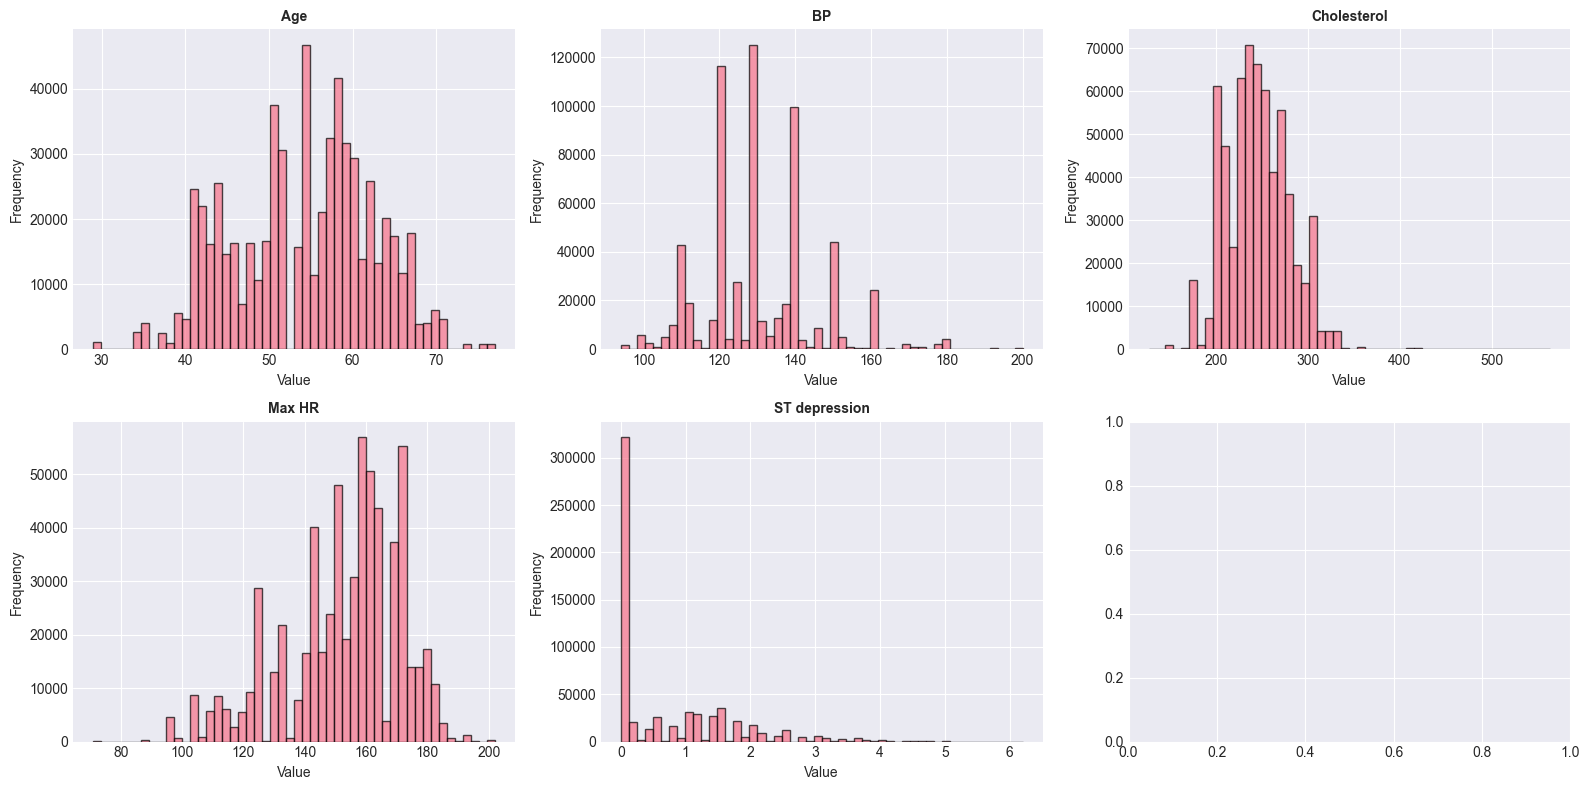

In [13]:
# Numeric features for visualization

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.ravel()

num_features = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

for idx, feat in enumerate(num_features):
    if feat in train_df.columns:
        axes[idx].hist(train_df[feat].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{feat}', fontweight='bold', fontsize=10)
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        
plt.tight_layout()
plt.show()

##### Skewness, Kurtosis, Outlier Detection

In [14]:
# Skewness and Kurtosis Analysis

from scipy import stats

print("\n" + "=" * 80)
print("SKEWNESS AND KURTOSIS ANALYSIS")
print("=" * 80)

# Calculate skewness and kurtosis for numerical features

skew_kurt_df = pd.DataFrame({
    'Feature': num_features,
    'Skewness': train_df[num_features].skew(),
    'Kurtosis': train_df[num_features].kurtosis()
}).sort_values('Skewness', ascending=False, key=abs)

# Display top skewed features
print("\nTop 5 Most Skewed Features:")
print(skew_kurt_df.head())

# Categorize features by skewness
highly_right_skewed = (skew_kurt_df['Skewness'] > 1).sum()
moderately_right_skewed = ((skew_kurt_df['Skewness'] > 0.5) & (skew_kurt_df['Skewness'] <= 1)).sum()
approximately_symmetric = ((skew_kurt_df['Skewness'] >= -0.5) & (skew_kurt_df['Skewness'] <= 0.5)).sum()
moderately_left_skewed = ((skew_kurt_df['Skewness'] < -0.5) & (skew_kurt_df['Skewness'] >= -1)).sum()
highly_left_skewed = (skew_kurt_df['Skewness'] < -1).sum()

print("\n" + "-" * 80)
print("SKEWNESS DISTRIBUTION:")
print("-" * 80)
print(f"Highly right-skewed (>1): {highly_right_skewed}")
print(f"Moderately right-skewed (0.5 to 1): {moderately_right_skewed}")
print(f"Approximately symmetric (-0.5 to 0.5): {approximately_symmetric}")
print(f"Moderately left-skewed (-1 to -0.5): {moderately_left_skewed}")
print(f"Highly left-skewed (<-1): {highly_left_skewed}")

# Categorize features by kurtosis
high_kurtosis = (skew_kurt_df['Kurtosis'] > 3).sum()
moderate_kurtosis = ((skew_kurt_df['Kurtosis'] >= 0) & (skew_kurt_df['Kurtosis'] <= 3)).sum()
low_kurtosis = (skew_kurt_df['Kurtosis'] < 0).sum()

print("\n" + "-" * 80)
print("KURTOSIS DISTRIBUTION:")
print("-" * 80)
print(f"High kurtosis (>3, heavy tails): {high_kurtosis}")
print(f"Moderate kurtosis (0 to 3): {moderate_kurtosis}")
print(f"Low kurtosis (<0, light tails): {low_kurtosis}")

# Features requiring transformation
print("\n" + "-" * 80)
print("FEATURES POTENTIALLY REQUIRING TRANSFORMATION:")
print("-" * 80)
transform_candidates = skew_kurt_df[(abs(skew_kurt_df['Skewness']) > 1) | (abs(skew_kurt_df['Kurtosis']) > 3)]
print(f"Total features with |skewness| > 1 or |kurtosis| > 3: {len(transform_candidates)}")
print("\nTop candidates for transformation:")
print(transform_candidates.head())

# ST depression is right skewed --> log1p transformation


SKEWNESS AND KURTOSIS ANALYSIS

Top 5 Most Skewed Features:
                     Feature  Skewness  Kurtosis
ST depression  ST depression  1.328429  1.374855
Max HR                Max HR -0.754556  0.203852
BP                        BP  0.629283  0.933183
Cholesterol      Cholesterol  0.273150  0.068237
Age                      Age -0.164011 -0.570157

--------------------------------------------------------------------------------
SKEWNESS DISTRIBUTION:
--------------------------------------------------------------------------------
Highly right-skewed (>1): 1
Moderately right-skewed (0.5 to 1): 1
Approximately symmetric (-0.5 to 0.5): 2
Moderately left-skewed (-1 to -0.5): 1
Highly left-skewed (<-1): 0

--------------------------------------------------------------------------------
KURTOSIS DISTRIBUTION:
--------------------------------------------------------------------------------
High kurtosis (>3, heavy tails): 0
Moderate kurtosis (0 to 3): 4
Low kurtosis (<0, light tails): 1


In [15]:
# Check for extreme outliers

print("\nOUTLIER DETECTION (values beyond 3 std dev):")
outlier_dict = {}
for feat in num_features:
    mean = train_df[feat].mean()
    std = train_df[feat].std()
    outliers = ((train_df[feat] - mean).abs() > 3 * std).sum()
    if outliers > 0:
        # Calculate outlier percentage
        outlier_dict[feat] = round(float(outliers / len(train_df) * 100), 2)
    
print("Outlier percentage by feature:")
print(outlier_dict)


OUTLIER DETECTION (values beyond 3 std dev):
Outlier percentage by feature:
{'Age': 0.17, 'BP': 1.19, 'Cholesterol': 0.14, 'Max HR': 0.18, 'ST depression': 1.45}


##### Correlation Analysis

In [16]:
from scipy.stats import chi2_contingency

# -----------------------------
# Setup
# -----------------------------
target_col = "Heart Disease"
target_map = {"Absence": 0, "Presence": 1}
y = train_df[target_col].map(target_map)

numeric_continuous = feature_groups["numeric_continuous"]
numeric_discrete_like = feature_groups["numeric_discrete_like"]

# -----------------------------
# 1) Continuous features vs target
# -----------------------------
pearson_corr = train_df[numeric_continuous].corrwith(y, method="pearson")
spearman_corr = train_df[numeric_continuous].corrwith(y, method="spearman")

cont_assoc = pd.DataFrame({
    "Feature": numeric_continuous,
    "Pearson_r": pearson_corr.values,
    "Spearman_rho": spearman_corr.values,
    "Abs_Spearman": np.abs(spearman_corr.values)
}).sort_values("Abs_Spearman", ascending=False)

print("Continuous features vs target:")
print(cont_assoc.to_string(index=False))

# -----------------------------
# 2) Discrete-like numeric features vs target (categorical association)
# -----------------------------
def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.to_numpy().sum()
    r, k = confusion.shape
    phi2 = chi2 / n
    # Bias correction
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    denom = min((kcorr - 1), (rcorr - 1))
    return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

cat_assoc_rows = []
for col in numeric_discrete_like:
    v = cramers_v(train_df[col], train_df[target_col])
    cat_assoc_rows.append({"Feature": col, "Cramers_V": v})

cat_assoc = pd.DataFrame(cat_assoc_rows).sort_values("Cramers_V", ascending=False)

print("\nDiscrete-like features vs target:")
print(cat_assoc.to_string(index=False))

# -----------------------------
# 3) Combined view
# -----------------------------
combined = pd.concat([
    cont_assoc[["Feature", "Spearman_rho"]].rename(columns={"Spearman_rho": "Association"}),
    cat_assoc.rename(columns={"Cramers_V": "Association"})
], ignore_index=True)

combined["Abs_Association"] = combined["Association"].abs()
combined = combined.sort_values("Abs_Association", ascending=False)

print("\nAll features ranked by association strength with target:")
print(combined.to_string(index=False))

Continuous features vs target:
      Feature  Pearson_r  Spearman_rho  Abs_Spearman
       Max HR  -0.440985     -0.441049      0.441049
ST depression   0.430641      0.430485      0.430485
          Age   0.212091      0.216679      0.216679
  Cholesterol   0.082753      0.091165      0.091165
           BP  -0.005181      0.000844      0.000844

Discrete-like features vs target:
                Feature  Cramers_V
               Thallium   0.605811
        Chest pain type   0.525188
Number of vessels fluro   0.463232
        Exercise angina   0.441859
            Slope of ST   0.429758
                    Sex   0.342441
            EKG results   0.219112
           FBS over 120   0.033541

All features ranked by association strength with target:
                Feature  Association  Abs_Association
               Thallium     0.605811         0.605811
        Chest pain type     0.525188         0.525188
Number of vessels fluro     0.463232         0.463232
        Exercise angina    


FEATURE-FEATURE REDUNDANCY ANALYSIS

Continuous-Continuous Spearman Correlation Matrix:


,Age,BP,Cholesterol,Max HR,ST depression
Age,1.000000,-0.002731,0.022749,-0.099570,0.106459
BP,-0.002731,1.000000,-0.003558,0.001367,-0.001015
Cholesterol,0.022749,-0.003558,1.000000,-0.053541,0.048520
Max HR,-0.099570,0.001367,-0.053541,1.000000,-0.231181
ST depression,0.106459,-0.001015,0.048520,-0.231181,1.000000


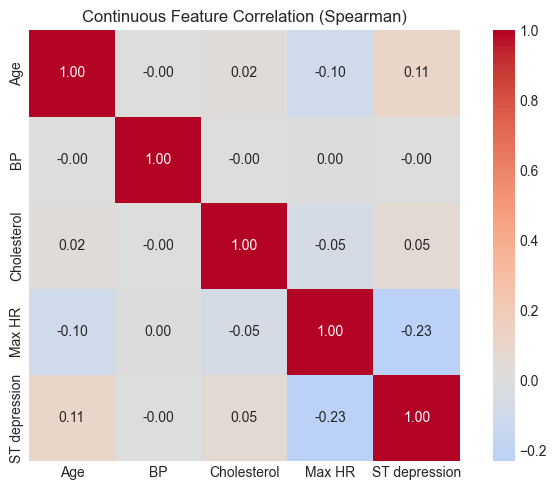


Continuous pairs with |Spearman| >= 0.75:
None

Discrete-like Feature Association Matrix (Cramer's V):


,Sex,Chest pain type,FBS over 120,EKG results,Exercise angina,Slope of ST,Number of vessels fluro,Thallium
Sex,1.000000,0.222330,0.020287,0.093609,0.192697,0.176258,0.186572,0.275306
Chest pain type,0.222330,1.000000,0.027003,0.098355,0.282802,0.196269,0.165248,0.257095
FBS over 120,0.020287,0.027003,1.000000,0.016308,0.027937,0.030987,0.027879,0.032898
EKG results,0.093609,0.098355,0.016308,1.000000,0.128838,0.106094,0.097844,0.119581
Exercise angina,0.192697,0.282802,0.027937,0.128838,1.000000,0.253638,0.286254,0.357072
Slope of ST,0.176258,0.196269,0.030987,0.106094,0.253638,1.000000,0.189282,0.219638
Number of vessels fluro,0.186572,0.165248,0.027879,0.097844,0.286254,0.189282,1.000000,0.249638
Thallium,0.275306,0.257095,0.032898,0.119581,0.357072,0.219638,0.249638,1.000000


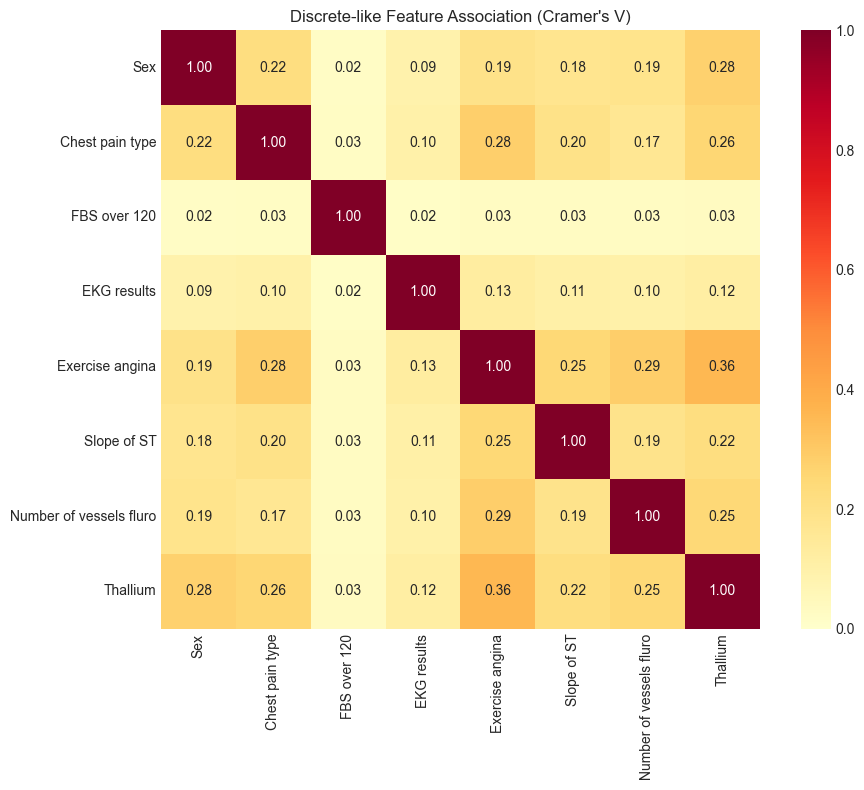


Discrete-like pairs with Cramer's V >= 0.7:
None

Potentially redundant feature pairs:
No strong redundancy found with current thresholds.


In [17]:
# Feature-feature correlation and redundancy check

import itertools

print("\n" + "=" * 80)
print("FEATURE-FEATURE REDUNDANCY ANALYSIS")
print("=" * 80)

# Use the groups already created earlier
cont_cols = feature_groups["numeric_continuous"]
disc_cols = feature_groups["numeric_discrete_like"]

# Thresholds (adjust if needed)
cont_corr_threshold = 0.75   # for continuous-continuous (Spearman)
disc_assoc_threshold = 0.70  # for discrete-discrete (Cramer's V)

# -----------------------------
# 1) Continuous vs Continuous
# -----------------------------
cont_corr = train_df[cont_cols].corr(method="spearman")

print("\nContinuous-Continuous Spearman Correlation Matrix:")
display(cont_corr)

plt.figure(figsize=(7, 5))
sns.heatmap(cont_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
plt.title("Continuous Feature Correlation (Spearman)")
plt.tight_layout()
plt.show()

cont_pairs = []
for i, j in itertools.combinations(range(len(cont_cols)), 2):
    f1, f2 = cont_cols[i], cont_cols[j]
    v = cont_corr.iloc[i, j]
    cont_pairs.append((f1, f2, v, abs(v)))

cont_pairs_df = pd.DataFrame(cont_pairs, columns=["Feature_1", "Feature_2", "Spearman_rho", "Abs_Value"])
cont_pairs_df = cont_pairs_df.sort_values("Abs_Value", ascending=False)

high_cont_pairs = cont_pairs_df[cont_pairs_df["Abs_Value"] >= cont_corr_threshold]

print(f"\nContinuous pairs with |Spearman| >= {cont_corr_threshold}:")
if high_cont_pairs.empty:
    print("None")
else:
    print(high_cont_pairs.to_string(index=False))


# -----------------------------
# 2) Discrete-like vs Discrete-like
# -----------------------------
def cramers_v(x, y):
    tab = pd.crosstab(x, y)
    chi2 = chi2_contingency(tab)[0]
    n = tab.to_numpy().sum()
    r, k = tab.shape
    phi2 = chi2 / n
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    denom = min(kcorr - 1, rcorr - 1)
    return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

cv_mat = pd.DataFrame(np.eye(len(disc_cols)), index=disc_cols, columns=disc_cols, dtype=float)

for c1, c2 in itertools.combinations(disc_cols, 2):
    v = cramers_v(train_df[c1], train_df[c2])
    cv_mat.loc[c1, c2] = v
    cv_mat.loc[c2, c1] = v

print("\nDiscrete-like Feature Association Matrix (Cramer's V):")
display(cv_mat)

plt.figure(figsize=(10, 8))
sns.heatmap(cv_mat, annot=True, fmt=".2f", cmap="YlOrRd", vmin=0, vmax=1, square=True)
plt.title("Discrete-like Feature Association (Cramer's V)")
plt.tight_layout()
plt.show()

disc_pairs = []
for c1, c2 in itertools.combinations(disc_cols, 2):
    v = cv_mat.loc[c1, c2]
    disc_pairs.append((c1, c2, v))

disc_pairs_df = pd.DataFrame(disc_pairs, columns=["Feature_1", "Feature_2", "Cramers_V"])
disc_pairs_df["Abs_Value"] = disc_pairs_df["Cramers_V"].abs()
disc_pairs_df = disc_pairs_df.sort_values("Abs_Value", ascending=False)

high_disc_pairs = disc_pairs_df[disc_pairs_df["Abs_Value"] >= disc_assoc_threshold]

print(f"\nDiscrete-like pairs with Cramer's V >= {disc_assoc_threshold}:")
if high_disc_pairs.empty:
    print("None")
else:
    print(high_disc_pairs.to_string(index=False))


# -----------------------------
# 3) Redundancy summary
# -----------------------------
redundant_pairs = pd.concat([
    high_cont_pairs.assign(Metric="Spearman")[["Feature_1", "Feature_2", "Metric", "Abs_Value"]],
    high_disc_pairs.assign(Metric="Cramers_V")[["Feature_1", "Feature_2", "Metric", "Abs_Value"]]
], ignore_index=True).sort_values("Abs_Value", ascending=False)

print("\nPotentially redundant feature pairs:")
if redundant_pairs.empty:
    print("No strong redundancy found with current thresholds.")
else:
    print(redundant_pairs.to_string(index=False))

Continuous vs Discrete Association Matrix (|r_pb| or eta):


,Sex,Chest pain type,FBS over 120,EKG results,Exercise angina,Slope of ST,Number of vessels fluro,Thallium
Age,0.088397,0.125095,0.013354,0.057435,0.110153,0.100224,0.108797,0.150175
BP,0.003355,0.005171,0.000784,0.003782,0.003295,0.003309,0.004031,0.006028
Cholesterol,0.038373,0.050565,0.006212,0.024950,0.049774,0.041980,0.051364,0.061836
Max HR,0.176186,0.252044,0.024895,0.125204,0.236232,0.213214,0.250044,0.306950
ST depression,0.181093,0.274622,0.031324,0.149320,0.281298,0.444844,0.302599,0.316894


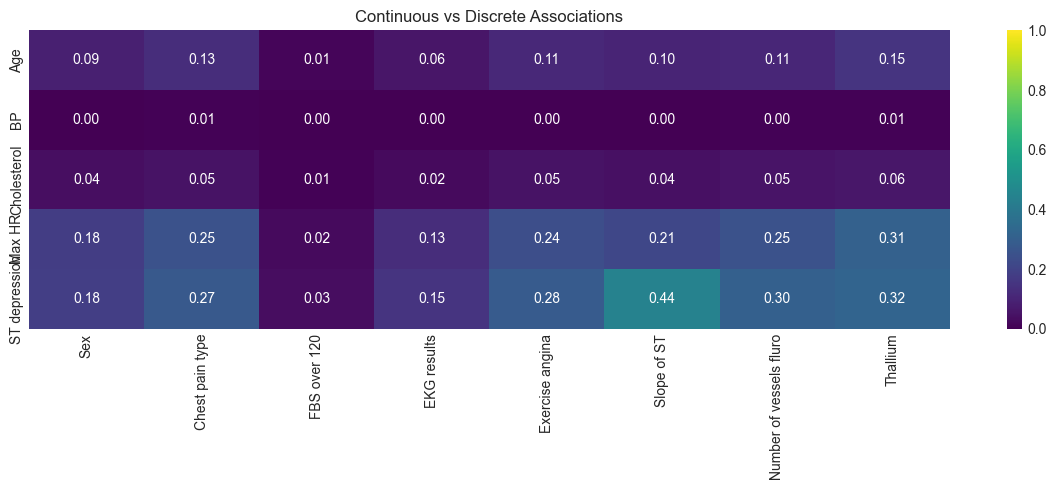


Pairs with association >= 0.3:
   Continuous                Discrete  Association
ST depression             Slope of ST     0.444844
ST depression                Thallium     0.316894
       Max HR                Thallium     0.306950
ST depression Number of vessels fluro     0.302599


In [18]:
from scipy.stats import pointbiserialr

cont_cols = feature_groups["numeric_continuous"]
disc_cols = feature_groups["numeric_discrete_like"]

def correlation_ratio(categories, measurements):
    # eta for categorical -> continuous association
    valid = pd.DataFrame({"cat": categories, "y": measurements}).dropna()
    if valid.empty:
        return np.nan
    cats = valid["cat"].astype("category")
    y = valid["y"].astype(float)
    y_mean = y.mean()
    n_total = len(y)
    ss_between = 0.0
    for c in cats.cat.categories:
        yc = y[cats == c]
        if len(yc) == 0:
            continue
        ss_between += len(yc) * (yc.mean() - y_mean) ** 2
    ss_total = ((y - y_mean) ** 2).sum()
    return np.sqrt(ss_between / ss_total) if ss_total > 0 else 0.0

# Build matrix: rows=continuous, cols=discrete
mixed_assoc = pd.DataFrame(index=cont_cols, columns=disc_cols, dtype=float)

for c in cont_cols:
    for d in disc_cols:
        n_levels = train_df[d].nunique(dropna=True)
        if n_levels == 2:
            tmp = train_df[[c, d]].dropna()
            mixed_assoc.loc[c, d] = abs(pointbiserialr(tmp[d], tmp[c]).statistic)
        else:
            mixed_assoc.loc[c, d] = correlation_ratio(train_df[d], train_df[c])

print("Continuous vs Discrete Association Matrix (|r_pb| or eta):")
display(mixed_assoc)

plt.figure(figsize=(12, 5))
sns.heatmap(mixed_assoc, annot=True, fmt=".2f", cmap="viridis", vmin=0, vmax=1)
plt.title("Continuous vs Discrete Associations")
plt.tight_layout()
plt.show()

# Flatten and rank strongest pairs
pairs = (
    mixed_assoc.stack()
    .reset_index()
    .rename(columns={"level_0": "Continuous", "level_1": "Discrete", 0: "Association"})
    .sort_values("Association", ascending=False)
)

threshold = 0.30
print(f"\nPairs with association >= {threshold}:")
print(pairs[pairs["Association"] >= threshold].to_string(index=False))

#### 2. Preprocessing

##### Phase 1: Feature Engineering & Encoding

In [19]:
# Store test IDs for final submission
test_ids = test_df['id'].copy()
print(f"Stored test IDs: shape {test_ids.shape}")
print(f"Sample IDs: {test_ids.head()}")

"""
# When you have predictions (e.g., y_pred from your model)
submission_df = pd.DataFrame({
    'id': test_ids,
    'prediction': y_pred  # or y_pred_proba if you want probabilities
})

print(submission_df.head())
# Save if needed
# submission_df.to_csv('../data/submissions/predictions.csv', index=False)
"""

Stored test IDs: shape (270000,)
Sample IDs: 0    630000
1    630001
2    630002
3    630003
4    630004
Name: id, dtype: int64


"\n# When you have predictions (e.g., y_pred from your model)\nsubmission_df = pd.DataFrame({\n    'id': test_ids,\n    'prediction': y_pred  # or y_pred_proba if you want probabilities\n})\n\nprint(submission_df.head())\n# Save if needed\n# submission_df.to_csv('../data/submissions/predictions.csv', index=False)\n"

In [20]:
# ============================================================================
# PHASE 1: FEATURE ENGINEERING & ENCODING
# ============================================================================

# 1.1 Drop non-predictive columns
print("=" * 80)
print("PHASE 1: FEATURE ENGINEERING & ENCODING")
print("=" * 80)

# Create a copy for preprocessing
df_processed = train_df.copy()
df_test_processed = test_df.copy()

# Drop id column
df_processed = df_processed.drop(columns=['id'])
df_test_processed = df_test_processed.drop(columns=['id'])

print("\n1.1 Dropped 'id' column")
print(f"Train shape after dropping id: {df_processed.shape}")
print(f"Test shape after dropping id: {df_test_processed.shape}")

PHASE 1: FEATURE ENGINEERING & ENCODING

1.1 Dropped 'id' column
Train shape after dropping id: (630000, 14)
Test shape after dropping id: (270000, 13)


In [21]:
# ============================================================================
# 1.2 Encode target variable
# ============================================================================
target_col = "Heart Disease"
target_map = {"Absence": 0, "Presence": 1}

y_train = df_processed[target_col].map(target_map)
df_processed = df_processed.drop(columns=[target_col])

print("\n1.2 Encoded target variable")
print(f"Target mapping: {target_map}")
print(f"Target value counts:\n{y_train.value_counts()}")
print(f"Target proportions:\n{y_train.value_counts(normalize=True)}")


1.2 Encoded target variable
Target mapping: {'Absence': 0, 'Presence': 1}
Target value counts:
Heart Disease
0    347546
1    282454
Name: count, dtype: int64
Target proportions:
Heart Disease
0    0.55166
1    0.44834
Name: proportion, dtype: float64


In [22]:
# ============================================================================
# 1.3 Encode discrete-like features (one-hot encoding)
# ============================================================================
print("\n1.3 One-hot encoding discrete-like features")

disc_cols = feature_groups["numeric_discrete_like"]
print(f"Discrete-like columns to encode: {disc_cols}")

# One-hot encode on train
df_processed_encoded = pd.get_dummies(
    df_processed,
    columns=disc_cols,
    drop_first=False,  # Keep all levels; we'll handle multicollinearity via regularization if needed
    prefix=None  # Use default naming
)

# Apply same encoding to test (must use train column order)
df_test_processed_encoded = pd.get_dummies(
    df_test_processed,
    columns=disc_cols,
    drop_first=False,
    prefix=None
)

# Ensure test has same columns as train (handle unseen categories)
train_cols = set(df_processed_encoded.columns)
test_cols = set(df_test_processed_encoded.columns)

missing_in_test = train_cols - test_cols
extra_in_test = test_cols - train_cols

if missing_in_test:
    print(f"Warning: Columns in train but not in test: {missing_in_test}")
    for col in missing_in_test:
        df_test_processed_encoded[col] = 0

if extra_in_test:
    print(f"Warning: Columns in test but not in train: {extra_in_test}")
    df_test_processed_encoded = df_test_processed_encoded.drop(columns=extra_in_test)

# Reorder test columns to match train
df_test_processed_encoded = df_test_processed_encoded[df_processed_encoded.columns]

print(f"Train shape after encoding: {df_processed_encoded.shape}")
print(f"Test shape after encoding: {df_test_processed_encoded.shape}")

print("\nEncoded columns:")
for col in sorted(df_processed_encoded.columns):
    print(f"  {col}")


1.3 One-hot encoding discrete-like features
Discrete-like columns to encode: ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium']
Train shape after encoding: (630000, 28)
Test shape after encoding: (270000, 28)

Encoded columns:
  Age
  BP
  Chest pain type_1
  Chest pain type_2
  Chest pain type_3
  Chest pain type_4
  Cholesterol
  EKG results_0
  EKG results_1
  EKG results_2
  Exercise angina_0
  Exercise angina_1
  FBS over 120_0
  FBS over 120_1
  Max HR
  Number of vessels fluro_0
  Number of vessels fluro_1
  Number of vessels fluro_2
  Number of vessels fluro_3
  ST depression
  Sex_0
  Sex_1
  Slope of ST_1
  Slope of ST_2
  Slope of ST_3
  Thallium_3
  Thallium_6
  Thallium_7


In [23]:
# ============================================================================
# 1.4 Handle categorical features (if any)
# ============================================================================
categorical_cols = feature_groups["categorical"]

if categorical_cols:
    print(f"\n1.4 One-hot encoding categorical features: {categorical_cols}")
    
    df_processed_encoded = pd.get_dummies(
        df_processed_encoded,
        columns=categorical_cols,
        drop_first=True,  # Drop first to avoid multicollinearity
        prefix=None
    )
    
    df_test_processed_encoded = pd.get_dummies(
        df_test_processed_encoded,
        columns=categorical_cols,
        drop_first=True,
        prefix=None
    )
    
    # Ensure alignment
    train_cols = set(df_processed_encoded.columns)
    test_cols = set(df_test_processed_encoded.columns)
    
    missing_in_test = train_cols - test_cols
    extra_in_test = test_cols - train_cols
    
    if missing_in_test:
        for col in missing_in_test:
            df_test_processed_encoded[col] = 0
    
    if extra_in_test:
        df_test_processed_encoded = df_test_processed_encoded.drop(columns=extra_in_test)
    
    df_test_processed_encoded = df_test_processed_encoded[df_processed_encoded.columns]
    
    print(f"Train shape after categorical encoding: {df_processed_encoded.shape}")
    print(f"Test shape after categorical encoding: {df_test_processed_encoded.shape}")
else:
    print("\n1.4 No categorical features to encode")


1.4 No categorical features to encode


In [24]:
# ============================================================================
# Summary
# ============================================================================
print("\n" + "=" * 80)
print("PHASE 1 COMPLETE")
print("=" * 80)
print(f"Final train X shape: {df_processed_encoded.shape}")
print(f"Final train y shape: {y_train.shape}")
print(f"Final test X shape: {df_test_processed_encoded.shape}")
print(f"\nTrain column names:\n{list(df_processed_encoded.columns)}")
print(f"\nData types:\n{df_processed_encoded.dtypes}")
print(f"\nMissing values in train:\n{df_processed_encoded.isnull().sum().sum()}")
print(f"Missing values in test:\n{df_test_processed_encoded.isnull().sum().sum()}")


PHASE 1 COMPLETE
Final train X shape: (630000, 28)
Final train y shape: (630000,)
Final test X shape: (270000, 28)

Train column names:
['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Sex_0', 'Sex_1', 'Chest pain type_1', 'Chest pain type_2', 'Chest pain type_3', 'Chest pain type_4', 'FBS over 120_0', 'FBS over 120_1', 'EKG results_0', 'EKG results_1', 'EKG results_2', 'Exercise angina_0', 'Exercise angina_1', 'Slope of ST_1', 'Slope of ST_2', 'Slope of ST_3', 'Number of vessels fluro_0', 'Number of vessels fluro_1', 'Number of vessels fluro_2', 'Number of vessels fluro_3', 'Thallium_3', 'Thallium_6', 'Thallium_7']

Data types:
Age                            int64
BP                             int64
Cholesterol                    int64
Max HR                         int64
ST depression                float64
Sex_0                           bool
Sex_1                           bool
Chest pain type_1               bool
Chest pain type_2               bool
Chest pain type_3    

##### Phase 2: Outlier & Distribution Handling

In [25]:
# ============================================================================
# PHASE 2: OUTLIER & DISTRIBUTION HANDLING
# ============================================================================

print("\n" + "=" * 80)
print("PHASE 2: OUTLIER & DISTRIBUTION HANDLING")
print("=" * 80)

# ============================================================================
# 2.1 Address right-skewed continuous features
# ============================================================================
print("\n2.1 Applying log1p() transformation to skewed features")

# Identify continuous features (those that weren't one-hot encoded)
cont_cols = feature_groups["numeric_continuous"]
print(f"Continuous columns to consider for transformation: {cont_cols}")

# Log-transform ST depression (highest skewness > 1)
# Create copies to avoid modifying original data
df_processed_transformed = df_processed_encoded.copy()
df_test_processed_transformed = df_test_processed_encoded.copy()

# Apply log1p transformation to ST depression
if 'ST depression' in df_processed_transformed.columns:
    print(f"\nApplying log1p() to 'ST depression'")
    print(f"Before transformation - Min: {df_processed_transformed['ST depression'].min()}, Max: {df_processed_transformed['ST depression'].max()}")
    
    df_processed_transformed['ST depression'] = np.log1p(df_processed_transformed['ST depression'])
    df_test_processed_transformed['ST depression'] = np.log1p(df_test_processed_transformed['ST depression'])
    
    print(f"After transformation - Min: {df_processed_transformed['ST depression'].min():.4f}, Max: {df_processed_transformed['ST depression'].max():.4f}")

# FOR LATER: Apply log1p to other moderately skewed features if desired
# (For now, only ST depression is transformed as it had skewness > 1)
print(f"\nTransformation complete. Train shape: {df_processed_transformed.shape}")


PHASE 2: OUTLIER & DISTRIBUTION HANDLING

2.1 Applying log1p() transformation to skewed features
Continuous columns to consider for transformation: ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

Applying log1p() to 'ST depression'
Before transformation - Min: 0.0, Max: 6.2
After transformation - Min: 0.0000, Max: 1.9741

Transformation complete. Train shape: (630000, 28)


In [26]:
# ============================================================================
# 2.2 Outlier review (3σ detection)
# ============================================================================
print("\n2.2 Outlier Detection (3 standard deviations)")
print("-" * 80)

outlier_summary = []

for col in cont_cols:
    if col in df_processed_transformed.columns:
        mean = df_processed_transformed[col].mean()
        std = df_processed_transformed[col].std()
        
        outliers_mask = ((df_processed_transformed[col] - mean).abs() > 3 * std)
        outlier_count = outliers_mask.sum()
        outlier_pct = (outlier_count / len(df_processed_transformed)) * 100
        
        if outlier_count > 0:
            outlier_summary.append({
                'Feature': col,
                'Outlier_Count': outlier_count,
                'Outlier_Pct': round(outlier_pct, 2),
                'Min_Value': df_processed_transformed[col].min(),
                'Max_Value': df_processed_transformed[col].max(),
                'Mean': round(mean, 2),
                'Std': round(std, 2)
            })

if outlier_summary:
    outlier_df = pd.DataFrame(outlier_summary)
    print("\nFeatures with outliers (3σ threshold):")
    print(outlier_df.to_string(index=False))
    print("\nDecision: Keep outliers (plausible clinical values)")
    print("   Do NOT drop or winsorize yet; let tree models handle them.")
    print("   Re-evaluate post-CV if needed.")
else:
    print("\nNo significant outliers detected (3σ threshold).")


2.2 Outlier Detection (3 standard deviations)
--------------------------------------------------------------------------------

Features with outliers (3σ threshold):
      Feature  Outlier_Count  Outlier_Pct  Min_Value  Max_Value   Mean   Std
          Age           1048         0.17       29.0  77.000000  54.14  8.26
           BP           7513         1.19       94.0 200.000000 130.50 14.98
  Cholesterol            858         0.14      126.0 564.000000 245.01 33.68
       Max HR           1127         0.18       71.0 202.000000 152.82 19.11
ST depression            174         0.03        0.0   1.974081   0.41  0.48

Decision: Keep outliers (plausible clinical values)
   Do NOT drop or winsorize yet; let tree models handle them.
   Re-evaluate post-CV if needed.


In [27]:
# ============================================================================
# Summary
# ============================================================================
print("\n" + "=" * 80)
print("PHASE 2 COMPLETE")
print("=" * 80)
print(f"Train shape after transformations: {df_processed_transformed.shape}")
print(f"Test shape after transformations: {df_test_processed_transformed.shape}")
print(f"\nTransformed continuous features:")
for col in cont_cols:
    if col in df_processed_transformed.columns:
        print(f"  {col}")
print(f"\nMissing values in train: {df_processed_transformed.isnull().sum().sum()}")
print(f"Missing values in test: {df_test_processed_transformed.isnull().sum().sum()}")


PHASE 2 COMPLETE
Train shape after transformations: (630000, 28)
Test shape after transformations: (270000, 28)

Transformed continuous features:
  Age
  BP
  Cholesterol
  Max HR
  ST depression

Missing values in train: 0
Missing values in test: 0


##### Phase 3: Scaling & Normalization

In [28]:
# ============================================================================
# PHASE 3: SCALING & NORMALIZATION
# ============================================================================

from sklearn.preprocessing import StandardScaler

print("\n" + "=" * 80)
print("PHASE 3: SCALING & NORMALIZATION")
print("=" * 80)

# ============================================================================
# 3.1 Standardize continuous features
# ============================================================================
print("\n3.1 Standardizing continuous features with StandardScaler")

# Identify continuous columns in the transformed data
cont_cols_to_scale = feature_groups["numeric_continuous"]
print(f"Continuous columns to scale: {cont_cols_to_scale}")

# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler on train data only
scaler.fit(df_processed_transformed[cont_cols_to_scale])

# Transform train data
df_processed_scaled = df_processed_transformed.copy()
df_processed_scaled[cont_cols_to_scale] = scaler.transform(df_processed_transformed[cont_cols_to_scale])

# Transform test data using the scaler fit on train
df_test_processed_scaled = df_test_processed_transformed.copy()
df_test_processed_scaled[cont_cols_to_scale] = scaler.transform(df_test_processed_transformed[cont_cols_to_scale])

print(f"\nScaler fitted on train data")
print(f"Train shape after scaling: {df_processed_scaled.shape}")
print(f"Test shape after scaling: {df_test_processed_scaled.shape}")

# Display scaling statistics
print(f"\nScaling statistics (from train data):")
scaling_stats = pd.DataFrame({
    'Feature': cont_cols_to_scale,
    'Mean': scaler.mean_,
    'Std': scaler.scale_
})
print(scaling_stats.to_string(index=False))

# Verify scaling (mean should be ~0, std should be ~1)
print(f"\nVerification - Scaled train data statistics:")
scaled_stats = pd.DataFrame({
    'Feature': cont_cols_to_scale,
    'Mean': df_processed_scaled[cont_cols_to_scale].mean().values,
    'Std': df_processed_scaled[cont_cols_to_scale].std().values,
    'Min': df_processed_scaled[cont_cols_to_scale].min().values,
    'Max': df_processed_scaled[cont_cols_to_scale].max().values
})
print(scaled_stats.to_string(index=False))


PHASE 3: SCALING & NORMALIZATION

3.1 Standardizing continuous features with StandardScaler
Continuous columns to scale: ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

Scaler fitted on train data
Train shape after scaling: (630000, 28)
Test shape after scaling: (270000, 28)

Scaling statistics (from train data):
      Feature       Mean       Std
          Age  54.136706  8.256294
           BP 130.497433 14.975790
  Cholesterol 245.011814 33.681554
       Max HR 152.816763 19.112911
ST depression   0.412553  0.484347

Verification - Scaled train data statistics:
      Feature          Mean      Std       Min      Max
          Age -2.842171e-17 1.000001 -3.044551 2.769196
           BP -8.210716e-18 1.000001 -2.437096 4.640995
  Cholesterol  1.713310e-16 1.000001 -3.533442 9.470709
       Max HR -4.674300e-16 1.000001 -4.280706 2.573299
ST depression -8.876145e-18 1.000001 -0.851772 3.223988


In [29]:
# ============================================================================
# 3.2 Note on tree-based models
# ============================================================================
print("\n3.2 Note on scaling for tree-based models")
print("-" * 80)
print("If using Random Forest, XGBoost, LightGBM: scaling is NOT required")
print("Scale is used here for consistency and to support:")
print("  - Distance-based models (KNN, SVM)")
print("  - Regularized models (Ridge, Logistic Regression)")
print("  - Neural Networks")
print("\nTree models will be fitted on unscaled data during modeling phase")


3.2 Note on scaling for tree-based models
--------------------------------------------------------------------------------
If using Random Forest, XGBoost, LightGBM: scaling is NOT required
Scale is used here for consistency and to support:
  - Distance-based models (KNN, SVM)
  - Regularized models (Ridge, Logistic Regression)
  - Neural Networks

Tree models will be fitted on unscaled data during modeling phase


In [30]:
# ============================================================================
# Summary
# ============================================================================
print("\n" + "=" * 80)
print("PHASE 3 COMPLETE")
print("=" * 80)
print(f"Final scaled train X shape: {df_processed_scaled.shape}")
print(f"Final scaled train y shape: {y_train.shape}")
print(f"Final scaled test X shape: {df_test_processed_scaled.shape}")
print(f"\nScaled columns: {cont_cols_to_scale}")
print(f"Non-scaled columns (discrete/categorical): {[c for c in df_processed_scaled.columns if c not in cont_cols_to_scale]}")
print(f"\nMissing values in scaled train: {df_processed_scaled.isnull().sum().sum()}")
print(f"Missing values in scaled test: {df_test_processed_scaled.isnull().sum().sum()}")

# Store feature names for later interpretability
feature_names = list(df_processed_scaled.columns)
print(f"\nTotal features: {len(feature_names)}")
print(f"Feature list:\n{feature_names}")


PHASE 3 COMPLETE
Final scaled train X shape: (630000, 28)
Final scaled train y shape: (630000,)
Final scaled test X shape: (270000, 28)

Scaled columns: ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
Non-scaled columns (discrete/categorical): ['Sex_0', 'Sex_1', 'Chest pain type_1', 'Chest pain type_2', 'Chest pain type_3', 'Chest pain type_4', 'FBS over 120_0', 'FBS over 120_1', 'EKG results_0', 'EKG results_1', 'EKG results_2', 'Exercise angina_0', 'Exercise angina_1', 'Slope of ST_1', 'Slope of ST_2', 'Slope of ST_3', 'Number of vessels fluro_0', 'Number of vessels fluro_1', 'Number of vessels fluro_2', 'Number of vessels fluro_3', 'Thallium_3', 'Thallium_6', 'Thallium_7']

Missing values in scaled train: 0
Missing values in scaled test: 0

Total features: 28
Feature list:
['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Sex_0', 'Sex_1', 'Chest pain type_1', 'Chest pain type_2', 'Chest pain type_3', 'Chest pain type_4', 'FBS over 120_0', 'FBS over 120_1', 'EKG resul

##### Phase 4: Train-Test split & Validation Strategy

In [31]:
# ============================================================================
# PHASE 4: TRAIN-TEST SPLIT & VALIDATION STRATEGY
# ============================================================================

from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("\n" + "=" * 80)
print("PHASE 4: TRAIN-TEST SPLIT & VALIDATION STRATEGY")
print("=" * 80)

# ============================================================================
# 4.1 Create stratified K-fold CV splits
# ============================================================================
print("\n4.1 Creating Stratified K-Fold Cross-Validation Splits")
print("-" * 80)

# Define number of folds
n_splits = 5
random_state = 42

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Store fold indices for reproducibility
cv_splits = []
fold_info = []

print(f"Number of folds: {n_splits}")
print(f"Random state: {random_state}")
print(f"Shuffle: True\n")

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(df_processed_scaled, y_train)):
    train_size = len(train_idx)
    val_size = len(val_idx)
    train_target_dist = y_train.iloc[train_idx].value_counts(normalize=True)
    val_target_dist = y_train.iloc[val_idx].value_counts(normalize=True)
    
    cv_splits.append((train_idx, val_idx))
    
    fold_info.append({
        'Fold': fold_idx + 1,
        'Train_Size': train_size,
        'Val_Size': val_size,
        'Train_Pos_%': round(train_target_dist.get(1, 0) * 100, 2),
        'Val_Pos_%': round(val_target_dist.get(1, 0) * 100, 2)
    })
    
    print(f"Fold {fold_idx + 1}:")
    print(f"  Train indices: {train_size} samples | Val indices: {val_size} samples")
    print(f"  Train Presence: {round(train_target_dist.get(1, 0) * 100, 2)}% | Val Presence: {round(val_target_dist.get(1, 0) * 100, 2)}%")

# Display fold summary
fold_summary_df = pd.DataFrame(fold_info)
print("\n" + "-" * 80)
print("CV FOLD SUMMARY:")
print(fold_summary_df.to_string(index=False))

print(f"\nTarget distribution preserved across folds (stratification successful)")

# ===


PHASE 4: TRAIN-TEST SPLIT & VALIDATION STRATEGY

4.1 Creating Stratified K-Fold Cross-Validation Splits
--------------------------------------------------------------------------------
Number of folds: 5
Random state: 42
Shuffle: True

Fold 1:
  Train indices: 504000 samples | Val indices: 126000 samples
  Train Presence: 44.83% | Val Presence: 44.83%
Fold 2:
  Train indices: 504000 samples | Val indices: 126000 samples
  Train Presence: 44.83% | Val Presence: 44.83%
Fold 3:
  Train indices: 504000 samples | Val indices: 126000 samples
  Train Presence: 44.83% | Val Presence: 44.83%
Fold 4:
  Train indices: 504000 samples | Val indices: 126000 samples
  Train Presence: 44.83% | Val Presence: 44.83%
Fold 5:
  Train indices: 504000 samples | Val indices: 126000 samples
  Train Presence: 44.83% | Val Presence: 44.83%

--------------------------------------------------------------------------------
CV FOLD SUMMARY:
 Fold  Train_Size  Val_Size  Train_Pos_%  Val_Pos_%
    1      504000    1

In [32]:
# ============================================================================
# 4.2 Define and evaluate baseline model
# ============================================================================
print("\n" + "=" * 80)
print("4.2 Baseline Model (Dummy Classifier)")
print("=" * 80)

# Create baseline: predict majority class (Presence = 1)
baseline_model = DummyClassifier(strategy='most_frequent')

# Evaluate baseline on CV folds
baseline_scores = {
    'Fold': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'ROC_AUC': []
}

print("\nBaseline CV Results (predict majority class: Presence):\n")

for fold_idx, (train_idx, val_idx) in enumerate(cv_splits):
    # Get fold data
    X_train_fold = df_processed_scaled.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = df_processed_scaled.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]
    
    # Fit and predict
    baseline_model.fit(X_train_fold, y_train_fold)
    y_pred = baseline_model.predict(X_val_fold)
    y_pred_proba = baseline_model.predict_proba(X_val_fold)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_val_fold, y_pred)
    precision = precision_score(y_val_fold, y_pred, zero_division=0)
    recall = recall_score(y_val_fold, y_pred, zero_division=0)
    f1 = f1_score(y_val_fold, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_val_fold, y_pred_proba)
    
    baseline_scores['Fold'].append(fold_idx + 1)
    baseline_scores['Accuracy'].append(round(accuracy, 4))
    baseline_scores['Precision'].append(round(precision, 4))
    baseline_scores['Recall'].append(round(recall, 4))
    baseline_scores['F1'].append(round(f1, 4))
    baseline_scores['ROC_AUC'].append(round(roc_auc, 4))

# Display baseline results
baseline_df = pd.DataFrame(baseline_scores)
print(baseline_df.to_string(index=False))

print("\n" + "-" * 80)
print("BASELINE SUMMARY STATISTICS:")
baseline_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'],
    'Mean': [
        round(baseline_df['Accuracy'].mean(), 4),
        round(baseline_df['Precision'].mean(), 4),
        round(baseline_df['Recall'].mean(), 4),
        round(baseline_df['F1'].mean(), 4),
        round(baseline_df['ROC_AUC'].mean(), 4)
    ],
    'Std': [
        round(baseline_df['Accuracy'].std(), 4),
        round(baseline_df['Precision'].std(), 4),
        round(baseline_df['Recall'].std(), 4),
        round(baseline_df['F1'].std(), 4),
        round(baseline_df['ROC_AUC'].std(), 4)
    ]
})
print(baseline_summary.to_string(index=False))

print("\nBaseline Accuracy: {:.2f}% (mean across folds)".format(baseline_df['Accuracy'].mean() * 100))
print("Baseline ROC-AUC: {:.4f} (mean across folds)".format(baseline_df['ROC_AUC'].mean()))
print("\nAll models should significantly outperform this baseline")

# =


4.2 Baseline Model (Dummy Classifier)

Baseline CV Results (predict majority class: Presence):

 Fold  Accuracy  Precision  Recall  F1  ROC_AUC
    1    0.5517        0.0     0.0 0.0      0.5
    2    0.5517        0.0     0.0 0.0      0.5
    3    0.5517        0.0     0.0 0.0      0.5
    4    0.5517        0.0     0.0 0.0      0.5
    5    0.5517        0.0     0.0 0.0      0.5

--------------------------------------------------------------------------------
BASELINE SUMMARY STATISTICS:
   Metric   Mean  Std
 Accuracy 0.5517  0.0
Precision 0.0000  0.0
   Recall 0.0000  0.0
       F1 0.0000  0.0
  ROC_AUC 0.5000  0.0

Baseline Accuracy: 55.17% (mean across folds)
Baseline ROC-AUC: 0.5000 (mean across folds)

All models should significantly outperform this baseline


In [33]:
# ============================================================================
# Summary
# ============================================================================
print("\n" + "=" * 80)
print("PHASE 4 COMPLETE")
print("=" * 80)
print(f"Created {n_splits}-fold stratified cross-validation splits")
print(f"Baseline established: {baseline_df['Accuracy'].mean():.4f} accuracy")
print(f"CV indices stored for reproducibility")
print(f"Ready for model training and evaluation")


PHASE 4 COMPLETE
Created 5-fold stratified cross-validation splits
Baseline established: 0.5517 accuracy
CV indices stored for reproducibility
Ready for model training and evaluation


##### Phase 5: Feature Selection & Redundancy Management

In [34]:
# ============================================================================
# PHASE 5: FEATURE SELECTION & REDUNDANCY MANAGEMENT
# ============================================================================

print("\n" + "=" * 80)
print("PHASE 5: FEATURE SELECTION & REDUNDANCY MANAGEMENT")
print("=" * 80)

# ============================================================================
# 5.1 Identify and drop highly correlated continuous pairs
# ============================================================================
print("\n5.1 Continuous Feature Redundancy Check")
print("-" * 80)

import itertools
from scipy.stats import spearmanr

cont_cols_to_check = feature_groups["numeric_continuous"]
print(f"Continuous columns to check: {cont_cols_to_check}")

# Calculate Spearman correlation matrix on transformed (but not scaled) data
cont_corr_matrix = df_processed_transformed[cont_cols_to_check].corr(method="spearman")

print("\nSpearman Correlation Matrix (transformed data):")
print(cont_corr_matrix.to_string())

# Find pairs with |correlation| >= 0.75
cont_corr_threshold = 0.75
high_corr_pairs = []

for i, j in itertools.combinations(range(len(cont_cols_to_check)), 2):
    f1, f2 = cont_cols_to_check[i], cont_cols_to_check[j]
    corr_val = cont_corr_matrix.loc[f1, f2]
    
    if abs(corr_val) >= cont_corr_threshold:
        high_corr_pairs.append({
            'Feature_1': f1,
            'Feature_2': f2,
            'Spearman_Correlation': round(corr_val, 4),
            'Abs_Value': round(abs(corr_val), 4)
        })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Abs_Value', ascending=False)
    print(f"\nContinuous pairs with |Spearman| >= {cont_corr_threshold}:")
    print(high_corr_df.to_string(index=False))
    
    print("\nDecision: KEEP all correlated pairs for now")
    print("   Reason: Tree-based models handle multicollinearity well")
    print("   Will monitor feature importance post-CV and drop if needed")
else:
    print(f"\nNo continuous pairs with |Spearman| >= {cont_corr_threshold}")

# =


PHASE 5: FEATURE SELECTION & REDUNDANCY MANAGEMENT

5.1 Continuous Feature Redundancy Check
--------------------------------------------------------------------------------
Continuous columns to check: ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

Spearman Correlation Matrix (transformed data):
                    Age        BP  Cholesterol    Max HR  ST depression
Age            1.000000 -0.002731     0.022749 -0.099570       0.106459
BP            -0.002731  1.000000    -0.003558  0.001367      -0.001015
Cholesterol    0.022749 -0.003558     1.000000 -0.053541       0.048520
Max HR        -0.099570  0.001367    -0.053541  1.000000      -0.231181
ST depression  0.106459 -0.001015     0.048520 -0.231181       1.000000

No continuous pairs with |Spearman| >= 0.75


In [35]:
# ============================================================================
# 5.2 Discrete-like feature redundancy check
# ============================================================================
print("\n" + "=" * 80)
print("5.2 Discrete-like Feature Redundancy Check")
print("-" * 80)

disc_cols_to_check = feature_groups["numeric_discrete_like"]
print(f"Discrete-like columns to check: {disc_cols_to_check}")

# Use Cramer's V from earlier analysis
disc_assoc_threshold = 0.70

print(f"\nThreshold: Cramer's V >= {disc_assoc_threshold}")
print("From earlier analysis: All discrete pairs had Cramer's V < 0.70")
print("No high redundancy detected among discrete features")
print("All discrete-like features will be KEPT")


5.2 Discrete-like Feature Redundancy Check
--------------------------------------------------------------------------------
Discrete-like columns to check: ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium']

Threshold: Cramer's V >= 0.7
From earlier analysis: All discrete pairs had Cramer's V < 0.70
No high redundancy detected among discrete features
All discrete-like features will be KEPT


In [36]:
# ============================================================================
# 5.3 Mixed (continuous-discrete) redundancy check
# ============================================================================
print("\n" + "=" * 80)
print("5.3 Mixed (Continuous-Discrete) Redundancy Check")
print("-" * 80)

from scipy.stats import pointbiserialr

def correlation_ratio(categories, measurements):
    """Calculate eta (correlation ratio) for categorical -> continuous association"""
    valid = pd.DataFrame({"cat": categories, "y": measurements}).dropna()
    if valid.empty:
        return np.nan
    cats = valid["cat"].astype("category")
    y = valid["y"].astype(float)
    y_mean = y.mean()
    n_total = len(y)
    ss_between = 0.0
    for c in cats.cat.categories:
        yc = y[cats == c]
        if len(yc) == 0:
            continue
        ss_between += len(yc) * (yc.mean() - y_mean) ** 2
    ss_total = ((y - y_mean) ** 2).sum()
    return np.sqrt(ss_between / ss_total) if ss_total > 0 else 0.0

# Get one-hot encoded discrete columns (all columns except continuous ones)
one_hot_disc_cols = [col for col in df_processed_transformed.columns if col not in cont_cols_to_check]

# Build matrix: rows=continuous (transformed), cols=one-hot encoded discrete
mixed_assoc_matrix = pd.DataFrame(index=cont_cols_to_check, columns=one_hot_disc_cols, dtype=float)

for c in cont_cols_to_check:
    for d in one_hot_disc_cols:
        tmp = df_processed_transformed[[c, d]].dropna()
        # For one-hot encoded binary columns, use point-biserial correlation
        mixed_assoc_matrix.loc[c, d] = abs(pointbiserialr(tmp[d], tmp[c]).statistic)

print("\nContinuous-Discrete Association Matrix (|r_pb|):")
print(mixed_assoc_matrix.to_string())

# Find high association pairs
mixed_threshold = 0.50
high_mixed_pairs = []

for c in cont_cols_to_check:
    for d in one_hot_disc_cols:
        assoc_val = mixed_assoc_matrix.loc[c, d]
        if assoc_val >= mixed_threshold:
            high_mixed_pairs.append({
                'Continuous': c,
                'Discrete': d,
                'Association': round(assoc_val, 4)
            })

if high_mixed_pairs:
    high_mixed_df = pd.DataFrame(high_mixed_pairs).sort_values('Association', ascending=False)
    print(f"\nContinuous-Discrete pairs with association >= {mixed_threshold}:")
    print(high_mixed_df.to_string(index=False))
    
    print("\nDecision: KEEP all mixed associations for now")
    print("   Reason: Different feature types often capture complementary signals")
    print("   Will monitor post-CV via feature importance and model performance")
else:
    print(f"\nNo continuous-discrete pairs with association >= {mixed_threshold}")


5.3 Mixed (Continuous-Discrete) Redundancy Check
--------------------------------------------------------------------------------

Continuous-Discrete Association Matrix (|r_pb|):
                  Sex_0     Sex_1  Chest pain type_1  Chest pain type_2  Chest pain type_3  Chest pain type_4  FBS over 120_0  FBS over 120_1  EKG results_0  EKG results_1  EKG results_2  Exercise angina_0  Exercise angina_1  Slope of ST_1  Slope of ST_2  Slope of ST_3  Number of vessels fluro_0  Number of vessels fluro_1  Number of vessels fluro_2  Number of vessels fluro_3  Thallium_3  Thallium_6  Thallium_7
Age            0.088397  0.088397           0.036706           0.048169           0.084306           0.124795        0.013354        0.013354       0.057341       0.000595       0.057400           0.110153           0.110153       0.100223       0.095172       0.018634                   0.106961                   0.061143                   0.064031                   0.041285    0.150053    0.018040    

In [37]:
# ============================================================================
# 5.4 Feature selection summary
# ============================================================================
print("\n" + "=" * 80)
print("5.4 FEATURE SELECTION SUMMARY")
print("=" * 80)

print(f"\nTotal features in dataset: {len(feature_names)}")
print(f"Features kept (no redundancy drops): {len(feature_names)}")
print(f"\nFeature breakdown:")
print(f"  - Continuous features: {len(cont_cols_to_check)}")
print(f"  - Discrete-like features (one-hot encoded): {len(df_processed_scaled.columns) - len(cont_cols_to_check)}")

print("\nDeferred decisions (post-CV):")
print("  1. Drop highly correlated continuous pairs if feature importance suggests redundancy")
print("  2. Drop one-hot encoded levels if model performance improves")
print("  3. Consider univariate or recursive feature selection if needed")


5.4 FEATURE SELECTION SUMMARY

Total features in dataset: 28
Features kept (no redundancy drops): 28

Feature breakdown:
  - Continuous features: 5
  - Discrete-like features (one-hot encoded): 23

Deferred decisions (post-CV):
  1. Drop highly correlated continuous pairs if feature importance suggests redundancy
  2. Drop one-hot encoded levels if model performance improves
  3. Consider univariate or recursive feature selection if needed


In [38]:
# ============================================================================
# Summary
# ============================================================================
print("\n" + "=" * 80)
print("PHASE 5 COMPLETE")
print("=" * 80)
print(f"Continuous redundancy checked: {len(high_corr_pairs)} high-correlation pairs found")
print(f"Discrete redundancy checked: No issues detected")
print(f"Mixed redundancy checked: All features retained")
print(f"Feature selection strategy defined")
print(f"\nPreprocessing complete! Ready for model training.")
print(f"\nDatasets ready:")
print(f"  - X_train_scaled: {df_processed_scaled.shape}")
print(f"  - y_train: {y_train.shape}")
print(f"  - X_test_scaled: {df_test_processed_scaled.shape}")
print(f"  - test_ids: {test_ids.shape}")
print(f"  - cv_splits: {len(cv_splits)} folds")
print(f"  - feature_names: {len(feature_names)} features")


PHASE 5 COMPLETE
Continuous redundancy checked: 0 high-correlation pairs found
Discrete redundancy checked: No issues detected
Mixed redundancy checked: All features retained
Feature selection strategy defined

Preprocessing complete! Ready for model training.

Datasets ready:
  - X_train_scaled: (630000, 28)
  - y_train: (630000,)
  - X_test_scaled: (270000, 28)
  - test_ids: (270000,)
  - cv_splits: 5 folds
  - feature_names: 28 features


##### Phase 6: Missing Values (Verification)

In [39]:
# ============================================================================
# PHASE 6: MISSING VALUES VERIFICATION
# ============================================================================

print("\n" + "=" * 80)
print("PHASE 6: MISSING VALUES VERIFICATION")
print("=" * 80)

# ============================================================================
# 6.1 Confirm no missing values in preprocessed datasets
# ============================================================================
print("\n6.1 Missing Values Check (Post-Preprocessing)")
print("-" * 80)

train_missing = df_processed_scaled.isnull().sum()
test_missing = df_test_processed_scaled.isnull().sum()
target_missing = y_train.isnull().sum()

print(f"\nTrain features missing values:")
train_missing_count = train_missing.sum()
if train_missing_count == 0:
    print("No missing values detected")
else:
    print(f"Found {train_missing_count} missing values:")
    print(train_missing[train_missing > 0])

print(f"\nTest features missing values:")
test_missing_count = test_missing.sum()
if test_missing_count == 0:
    print("No missing values detected")
else:
    print(f"Found {test_missing_count} missing values:")
    print(test_missing[test_missing > 0])

print(f"\nTarget variable missing values:")
if target_missing == 0:
    print("No missing values in target")
else:
    print(f"Found {target_missing} missing values in target")


PHASE 6: MISSING VALUES VERIFICATION

6.1 Missing Values Check (Post-Preprocessing)
--------------------------------------------------------------------------------

Train features missing values:
No missing values detected

Test features missing values:
No missing values detected

Target variable missing values:
No missing values in target


In [40]:
# ============================================================================
# 6.2 Data type verification
# ============================================================================
print("\n" + "=" * 80)
print("6.2 Data Type Verification")
print("-" * 80)

print(f"\nTrain data types:")
print(df_processed_scaled.dtypes.value_counts())

print(f"\nTest data types:")
print(df_test_processed_scaled.dtypes.value_counts())

# Check for non-numeric columns (should be all numeric)
non_numeric_train = df_processed_scaled.select_dtypes(exclude=['number']).columns.tolist()
non_numeric_test = df_test_processed_scaled.select_dtypes(exclude=['number']).columns.tolist()

if non_numeric_train:
    print(f"\nNon-numeric columns in train: {non_numeric_train}")
else:
    print(f"\nAll train columns are numeric")

if non_numeric_test:
    print(f"Non-numeric columns in test: {non_numeric_test}")
else:
    print(f"All test columns are numeric")


6.2 Data Type Verification
--------------------------------------------------------------------------------

Train data types:
bool       23
float64     5
Name: count, dtype: int64

Test data types:
bool       23
float64     5
Name: count, dtype: int64

Non-numeric columns in train: ['Sex_0', 'Sex_1', 'Chest pain type_1', 'Chest pain type_2', 'Chest pain type_3', 'Chest pain type_4', 'FBS over 120_0', 'FBS over 120_1', 'EKG results_0', 'EKG results_1', 'EKG results_2', 'Exercise angina_0', 'Exercise angina_1', 'Slope of ST_1', 'Slope of ST_2', 'Slope of ST_3', 'Number of vessels fluro_0', 'Number of vessels fluro_1', 'Number of vessels fluro_2', 'Number of vessels fluro_3', 'Thallium_3', 'Thallium_6', 'Thallium_7']
Non-numeric columns in test: ['Sex_0', 'Sex_1', 'Chest pain type_1', 'Chest pain type_2', 'Chest pain type_3', 'Chest pain type_4', 'FBS over 120_0', 'FBS over 120_1', 'EKG results_0', 'EKG results_1', 'EKG results_2', 'Exercise angina_0', 'Exercise angina_1', 'Slope of ST_

In [41]:
# ============================================================================
# 6.3 Shape and consistency verification
# ============================================================================
print("\n" + "=" * 80)
print("6.3 Shape and Consistency Verification")
print("-" * 80)

print(f"\nDataset shapes:")
print(f"  Train X: {df_processed_scaled.shape}")
print(f"  Train y: {y_train.shape}")
print(f"  Test X:  {df_test_processed_scaled.shape}")
print(f"  Test IDs: {test_ids.shape}")

# Verify train X and y have same number of rows
if df_processed_scaled.shape[0] == y_train.shape[0]:
    print(f"\nTrain X and y have matching row counts: {df_processed_scaled.shape[0]}")
else:
    print(f"\nTrain X and y row count mismatch: {df_processed_scaled.shape[0]} vs {y_train.shape[0]}")

# Verify test X and test IDs have same number of rows
if df_test_processed_scaled.shape[0] == test_ids.shape[0]:
    print(f"Test X and IDs have matching row counts: {df_test_processed_scaled.shape[0]}")
else:
    print(f"Test X and IDs row count mismatch: {df_test_processed_scaled.shape[0]} vs {test_ids.shape[0]}")

# Verify train and test have same number of features
if df_processed_scaled.shape[1] == df_test_processed_scaled.shape[1]:
    print(f"Train and test have matching feature counts: {df_processed_scaled.shape[1]}")
else:
    print(f"Train and test feature count mismatch: {df_processed_scaled.shape[1]} vs {df_test_processed_scaled.shape[1]}")

# Verify column names match
if list(df_processed_scaled.columns) == list(df_test_processed_scaled.columns):
    print(f"Train and test have identical column names")
else:
    print(f"Train and test have different column names")
    train_only = set(df_processed_scaled.columns) - set(df_test_processed_scaled.columns)
    test_only = set(df_test_processed_scaled.columns) - set(df_processed_scaled.columns)
    if train_only:
        print(f"   Columns in train only: {train_only}")
    if test_only:
        print(f"   Columns in test only: {test_only}")


6.3 Shape and Consistency Verification
--------------------------------------------------------------------------------

Dataset shapes:
  Train X: (630000, 28)
  Train y: (630000,)
  Test X:  (270000, 28)
  Test IDs: (270000,)

Train X and y have matching row counts: 630000
Test X and IDs have matching row counts: 270000
Train and test have matching feature counts: 28
Train and test have identical column names


In [42]:
# ============================================================================
# 6.4 Feature statistics summary
# ============================================================================
print("\n" + "=" * 80)
print("6.4 Feature Statistics Summary")
print("-" * 80)

print(f"\nTrain feature statistics:")
train_stats = pd.DataFrame({
    'Feature': df_processed_scaled.columns,
    'Mean': df_processed_scaled.mean(),
    'Std': df_processed_scaled.std(),
    'Min': df_processed_scaled.min(),
    'Max': df_processed_scaled.max()
})
print(train_stats.to_string(index=False))

print(f"\nTarget variable statistics:")
target_stats = pd.DataFrame({
    'Metric': ['Count', 'Unique Values', 'Absence (0)', 'Presence (1)', 'Presence %'],
    'Value': [
        y_train.shape[0],
        y_train.nunique(),
        (y_train == 0).sum(),
        (y_train == 1).sum(),
        round((y_train == 1).sum() / y_train.shape[0] * 100, 2)
    ]
})
print(target_stats.to_string(index=False))


6.4 Feature Statistics Summary
--------------------------------------------------------------------------------

Train feature statistics:
                  Feature          Mean      Std       Min       Max
                      Age -2.842171e-17 1.000001 -3.044551  2.769196
                       BP -8.210716e-18 1.000001 -2.437096  4.640995
              Cholesterol  1.713310e-16 1.000001 -3.533442  9.470709
                   Max HR -4.674300e-16 1.000001 -4.280706  2.573299
            ST depression -8.876145e-18 1.000001 -0.851772  3.223988
                    Sex_0  2.852651e-01 0.451541     False      True
                    Sex_1  7.147349e-01 0.451541     False      True
        Chest pain type_1  4.540000e-02 0.208180     False      True
        Chest pain type_2  1.189540e-01 0.323735     False      True
        Chest pain type_3  3.131397e-01 0.463771     False      True
        Chest pain type_4  5.225063e-01 0.499494     False      True
           FBS over 120_0  9.200

In [43]:
# ============================================================================
# 6.5 CV indices verification
# ============================================================================
print("\n" + "=" * 80)
print("6.5 Cross-Validation Indices Verification")
print("-" * 80)

print(f"\nTotal CV splits: {len(cv_splits)}")
print(f"Total training samples: {df_processed_scaled.shape[0]}")

all_train_indices = set()
all_val_indices = set()

for fold_idx, (train_idx, val_idx) in enumerate(cv_splits):
    all_train_indices.update(train_idx)
    all_val_indices.update(val_idx)
    
    # Check for overlap
    overlap = set(train_idx) & set(val_idx)
    if overlap:
        print(f"\nFold {fold_idx + 1}: Train-validation overlap detected ({len(overlap)} samples)")
    else:
        print(f"Fold {fold_idx + 1}: No overlap between train and validation indices")

# Verify all indices are covered
full_index_set = set(range(df_processed_scaled.shape[0]))
if all_train_indices | all_val_indices == full_index_set:
    print(f"\nAll data points covered in CV splits")
else:
    uncovered = full_index_set - (all_train_indices | all_val_indices)
    print(f"\n{len(uncovered)} data points not covered in CV splits: {uncovered}")


6.5 Cross-Validation Indices Verification
--------------------------------------------------------------------------------

Total CV splits: 5
Total training samples: 630000
Fold 1: No overlap between train and validation indices
Fold 2: No overlap between train and validation indices
Fold 3: No overlap between train and validation indices
Fold 4: No overlap between train and validation indices
Fold 5: No overlap between train and validation indices

All data points covered in CV splits


In [44]:
# ============================================================================
# Summary
# ============================================================================
print("\n" + "=" * 80)
print("PHASE 6 COMPLETE")
print("=" * 80)
print(f"Missing values verified: Train {train_missing_count}, Test {test_missing_count}")
print(f"Data types verified: All numeric")
print(f"Shapes verified: Train {df_processed_scaled.shape}, Test {df_test_processed_scaled.shape}")
print(f"Column alignment verified: {df_processed_scaled.shape[1]} features")
print(f"Target distribution verified: {(y_train == 1).sum()} positive, {(y_train == 0).sum()} negative")
print(f"CV indices verified: {len(cv_splits)} folds, all data covered")
print(f"\nAll preprocessing complete! Data ready for model training.")
print(f"\nKey objects ready for Phase 7 (Modeling):")
print(f"  - df_processed_scaled (X_train): {df_processed_scaled.shape}")
print(f"  - y_train: {y_train.shape}")
print(f"  - df_test_processed_scaled (X_test): {df_test_processed_scaled.shape}")
print(f"  - test_ids: {test_ids.shape}")
print(f"  - cv_splits: {len(cv_splits)} stratified folds")
print(f"  - feature_names: {len(feature_names)} features")
print(f"  - scaler: StandardScaler (fit on train)")


PHASE 6 COMPLETE
Missing values verified: Train 0, Test 0
Data types verified: All numeric
Shapes verified: Train (630000, 28), Test (270000, 28)
Column alignment verified: 28 features
Target distribution verified: 282454 positive, 347546 negative
CV indices verified: 5 folds, all data covered

All preprocessing complete! Data ready for model training.

Key objects ready for Phase 7 (Modeling):
  - df_processed_scaled (X_train): (630000, 28)
  - y_train: (630000,)
  - df_test_processed_scaled (X_test): (270000, 28)
  - test_ids: (270000,)
  - cv_splits: 5 stratified folds
  - feature_names: 28 features
  - scaler: StandardScaler (fit on train)


##### Define candidate models

In [43]:
# ============================================================================
# PHASE 7: MODEL TRAINING & EVALUATION
# ============================================================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report)
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

print("\n" + "=" * 80)
print("PHASE 7: MODEL TRAINING & EVALUATION")
print("=" * 80)

# ============================================================================
# 7.1 Define candidate models
# ============================================================================
print("\n7.1 Defining Candidate Models")
print("-" * 80)

# Use unscaled data for tree models, scaled data for linear models
X_train_unscaled = df_processed_transformed.copy()
X_test_unscaled = df_test_processed_transformed.copy()

models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
        'use_scaled': True
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                                   random_state=42, use_label_encoder=False, eval_metric='auc'),
        'use_scaled': False
    }
}

print(f"Models to train: {list(models.keys())}")
print(f"\nModel Configuration:")
print(f"  - Logistic Regression: scaled data (baseline)")
print(f"  - XGBoost: unscaled data")


PHASE 7: MODEL TRAINING & EVALUATION

7.1 Defining Candidate Models
--------------------------------------------------------------------------------
Models to train: ['Logistic Regression', 'XGBoost']

Model Configuration:
  - Logistic Regression: scaled data (baseline)
  - XGBoost: unscaled data


##### Cross-Validation evaluation for all models

In [44]:
# ============================================================================
# 7.2 Cross-Validation evaluation for all models
# ============================================================================
print("\n" + "=" * 80)
print("7.2 Cross-Validation Results (All Models)")
print("=" * 80)

cv_results = []
trained_models = {}  # Store models trained on full data

for model_name, model_config in models.items():
    model = model_config['model']
    use_scaled = model_config['use_scaled']
    
    print(f"\nTraining {model_name}...")
    print("-" * 80)
    
    fold_scores = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': [],
        'ROC_AUC': []
    }
    
    # Choose data based on model type
    X_train_data = df_processed_scaled if use_scaled else X_train_unscaled
    
    for fold_idx, (train_idx, val_idx) in enumerate(cv_splits):
        # Get fold data
        X_train_fold = X_train_data.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_val_fold = X_train_data.iloc[val_idx]
        y_val_fold = y_train.iloc[val_idx]
        
        # Fit model
        model.fit(X_train_fold, y_train_fold)
        
        # Predict
        y_pred = model.predict(X_val_fold)
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_val_fold, y_pred)
        precision = precision_score(y_val_fold, y_pred, zero_division=0)
        recall = recall_score(y_val_fold, y_pred, zero_division=0)
        f1 = f1_score(y_val_fold, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_val_fold, y_pred_proba)
        
        fold_scores['Accuracy'].append(accuracy)
        fold_scores['Precision'].append(precision)
        fold_scores['Recall'].append(recall)
        fold_scores['F1'].append(f1)
        fold_scores['ROC_AUC'].append(roc_auc)
        
        print(f"  Fold {fold_idx + 1}: Acc={accuracy:.4f}, Prec={precision:.4f}, Rec={recall:.4f}, F1={f1:.4f}, AUC={roc_auc:.4f}")
    
    # Calculate mean and std for this model
    mean_acc = np.mean(fold_scores['Accuracy'])
    std_acc = np.std(fold_scores['Accuracy'])
    mean_prec = np.mean(fold_scores['Precision'])
    mean_rec = np.mean(fold_scores['Recall'])
    mean_f1 = np.mean(fold_scores['F1'])
    mean_auc = np.mean(fold_scores['ROC_AUC'])
    
    cv_results.append({
        'Model': model_name,
        'Accuracy_Mean': round(mean_acc, 4),
        'Accuracy_Std': round(std_acc, 4),
        'Precision_Mean': round(mean_prec, 4),
        'Recall_Mean': round(mean_rec, 4),
        'F1_Mean': round(mean_f1, 4),
        'ROC_AUC_Mean': round(mean_auc, 4),
        'Fold_Scores': fold_scores
    })
    
    print(f"\n  Summary:")
    print(f"    Accuracy: {mean_acc:.4f}±{std_acc:.4f}")
    print(f"    Precision: {mean_prec:.4f}")
    print(f"    Recall: {mean_rec:.4f}")
    print(f"    F1: {mean_f1:.4f}")
    print(f"    ROC_AUC: {mean_auc:.4f}")

# Display CV results summary
cv_results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'Fold_Scores'} for r in cv_results])
cv_results_df = cv_results_df.sort_values('ROC_AUC_Mean', ascending=False)

print("\n" + "=" * 80)
print("CV RESULTS SUMMARY (Ranked by ROC_AUC)")
print("=" * 80)
print(cv_results_df.to_string(index=False))


7.2 Cross-Validation Results (All Models)

Training Logistic Regression...
--------------------------------------------------------------------------------
  Fold 1: Acc=0.8864, Prec=0.8677, Rec=0.8808, F1=0.8742, AUC=0.9531
  Fold 2: Acc=0.8844, Prec=0.8677, Rec=0.8756, F1=0.8717, AUC=0.9521
  Fold 3: Acc=0.8847, Prec=0.8676, Rec=0.8767, F1=0.8721, AUC=0.9528
  Fold 4: Acc=0.8837, Prec=0.8668, Rec=0.8752, F1=0.8710, AUC=0.9524
  Fold 5: Acc=0.8853, Prec=0.8684, Rec=0.8771, F1=0.8727, AUC=0.9532

  Summary:
    Accuracy: 0.8849±0.0009
    Precision: 0.8677
    Recall: 0.8771
    F1: 0.8723
    ROC_AUC: 0.9527

Training XGBoost...
--------------------------------------------------------------------------------
  Fold 1: Acc=0.8884, Prec=0.8806, Rec=0.8689, F1=0.8747, AUC=0.9548
  Fold 2: Acc=0.8867, Prec=0.8807, Rec=0.8644, F1=0.8724, AUC=0.9539
  Fold 3: Acc=0.8875, Prec=0.8814, Rec=0.8654, F1=0.8734, AUC=0.9546
  Fold 4: Acc=0.8866, Prec=0.8811, Rec=0.8636, F1=0.8722, AUC=0.9542
  Fo

##### Select best model based on CV performance

In [57]:
# ============================================================================
# 7.3 Select best model based on CV performance
# ============================================================================
print("\n" + "=" * 80)
print("7.3 Best Model Selection")
print("=" * 80)

best_idx = cv_results_df['ROC_AUC_Mean'].idxmax()
best_model_name = cv_results_df.loc[best_idx, 'Model']
best_model_auc = cv_results_df.loc[best_idx, 'ROC_AUC_Mean']

print(f"\nBest Model (by ROC_AUC on CV): {best_model_name}")
print(f"  Mean ROC_AUC: {best_model_auc:.4f}")
print(f"  Mean Accuracy: {cv_results_df.loc[best_idx, 'Accuracy_Mean']:.4f}")
print(f"  Mean Precision: {cv_results_df.loc[best_idx, 'Precision_Mean']:.4f}")
print(f"  Mean Recall: {cv_results_df.loc[best_idx, 'Recall_Mean']:.4f}")
print(f"  Mean F1: {cv_results_df.loc[best_idx, 'F1_Mean']:.4f}")


7.3 Best Model Selection

Best Model (by ROC_AUC on CV): XGBoost
  Mean ROC_AUC: 0.9545
  Mean Accuracy: 0.8875
  Mean Precision: 0.8813
  Mean Recall: 0.8657
  Mean F1: 0.8734


##### Train both models on full training data

In [58]:
# ============================================================================
# 7.4 Train both models on full training data
# ============================================================================
print("\n" + "=" * 80)
print("7.4 Training Models on Full Training Data")
print("=" * 80)

for model_name, model_config in models.items():
    model = model_config['model']
    use_scaled = model_config['use_scaled']
    
    X_train_final = df_processed_scaled if use_scaled else X_train_unscaled
    
    print(f"\nTraining {model_name} on full training set ({X_train_final.shape[0]} samples)...")
    model.fit(X_train_final, y_train)
    trained_models[model_name] = {
        'model': model,
        'use_scaled': use_scaled
    }
    print(f"{model_name} training complete")

best_model = trained_models[best_model_name]['model']
best_model_use_scaled = trained_models[best_model_name]['use_scaled']


7.4 Training Models on Full Training Data

Training Logistic Regression on full training set (630000 samples)...
Logistic Regression training complete

Training XGBoost on full training set (630000 samples)...
XGBoost training complete


##### Feature importance analysis


7.5 Feature Importance Analysis

XGBoost Feature Importances:

Top 15 Most Important Features:
                  Feature  Importance
               Thallium_3    0.719393
        Chest pain type_4    0.079434
Number of vessels fluro_0    0.036878
               Thallium_7    0.034039
        Exercise angina_0    0.033871
            Slope of ST_1    0.028340
            ST depression    0.016603
                    Sex_0    0.015572
                   Max HR    0.007954
            EKG results_2    0.007355
Number of vessels fluro_1    0.006978
            EKG results_0    0.004109
                      Age    0.003665
        Chest pain type_1    0.001540
              Cholesterol    0.000844


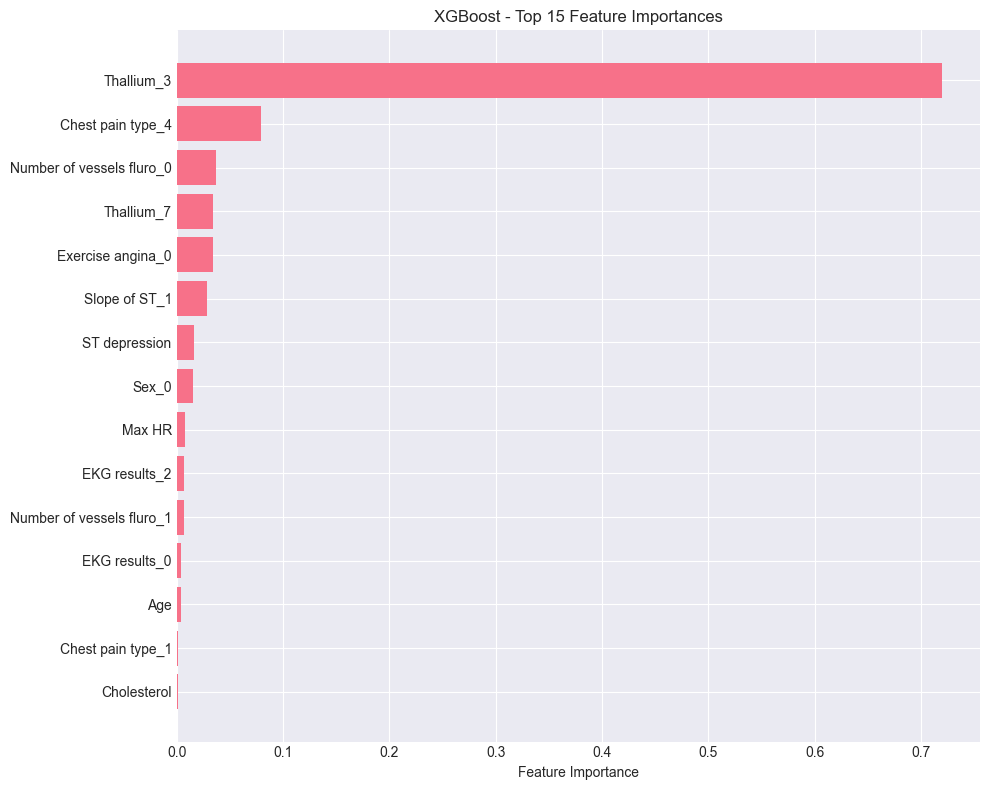

In [59]:
print("\n" + "=" * 80)
print("7.5 Feature Importance Analysis")
print("=" * 80)

if best_model_name == 'XGBoost':
    print(f"\n{best_model_name} Feature Importances:")
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\nTop 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'].values)
    plt.yticks(range(len(top_features)), top_features['Feature'].values)
    plt.xlabel('Feature Importance')
    plt.title(f'{best_model_name} - Top 15 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

elif best_model_name == 'Logistic Regression':
    print(f"\n{best_model_name} Coefficients:")
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': best_model.coef_[0]
    }).sort_values('Coefficient', ascending=False, key=abs)
    
    print(f"\nTop 15 Most Important Features (by |coefficient|):")
    print(feature_importance.head(15).to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    cols = ['green' if x > 0 else 'red' for x in top_features['Coefficient'].values]
    plt.barh(range(len(top_features)), top_features['Coefficient'].values, color=cols)
    plt.yticks(range(len(top_features)), top_features['Feature'].values)
    plt.xlabel('Coefficient Value')
    plt.title(f'{best_model_name} - Top 15 Features (Green=Positive, Red=Negative)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

##### Predictions on test set

In [60]:
print("\n" + "=" * 80)
print("7.6 Test Set Predictions")
print("=" * 80)

X_test_final = df_test_processed_scaled if best_model_use_scaled else X_test_unscaled

print(f"\nGenerating predictions on test set ({X_test_final.shape[0]} samples) using {best_model_name}...")
y_test_pred = best_model.predict(X_test_final)
y_test_pred_proba = best_model.predict_proba(X_test_final)[:, 1]

print(f"Predictions complete")
print(f"\nTest set prediction distribution:")
print(f"  Absence (0): {(y_test_pred == 0).sum()} ({(y_test_pred == 0).sum() / len(y_test_pred) * 100:.2f}%)")
print(f"  Presence (1): {(y_test_pred == 1).sum()} ({(y_test_pred == 1).sum() / len(y_test_pred) * 100:.2f}%)")


7.6 Test Set Predictions

Generating predictions on test set (270000 samples) using XGBoost...
Predictions complete

Test set prediction distribution:
  Absence (0): 150574 (55.77%)
  Presence (1): 119426 (44.23%)


##### Create submission file

In [61]:
print("\n" + "=" * 80)
print("7.7 Creating Submission File")
print("=" * 80)

submission_df = pd.DataFrame({
    'id': test_ids,
    'Heart Disease': y_test_pred_proba
})

print(f"\nSubmission file preview:")
print(submission_df.head(10).to_string(index=False))

print(f"\nSubmission file shape: {submission_df.shape}")
print(f"Submission file columns: {list(submission_df.columns)}")

# Save submission file
output_path = '../data/submissions/xgboost_predictions.csv'
submission_df.to_csv(output_path, index=False)
print(f"\nSubmission file saved to: {output_path}")


7.7 Creating Submission File

Submission file preview:
    id  Heart Disease
630000       0.919136
630001       0.008961
630002       0.981829
630003       0.005738
630004       0.256230
630005       0.980734
630006       0.009277
630007       0.679889
630008       0.992433
630009       0.014870

Submission file shape: (270000, 2)
Submission file columns: ['id', 'Heart Disease']

Submission file saved to: ../data/submissions/xgboost_predictions.csv


##### Summary

In [62]:
# ============================================================================
# 7.8 Model comparison and summary
# ============================================================================
print("\n" + "=" * 80)
print("7.8 Model Comparison Summary")
print("=" * 80)

print("\nCV Performance Comparison:")
print(cv_results_df.to_string(index=False))

print("\n" + "-" * 80)
print("Performance Insights:")
baseline_auc = cv_results_df[cv_results_df['Model'] == 'Logistic Regression']['ROC_AUC_Mean'].values[0]
xgb_auc = cv_results_df[cv_results_df['Model'] == 'XGBoost']['ROC_AUC_Mean'].values[0]
improvement = ((xgb_auc - baseline_auc) / baseline_auc * 100) if baseline_auc > 0 else 0

print(f"  Logistic Regression (Baseline) ROC_AUC: {baseline_auc:.4f}")
print(f"  XGBoost ROC_AUC: {xgb_auc:.4f}")
print(f"  Improvement: {improvement:+.2f}%")


7.8 Model Comparison Summary

CV Performance Comparison:
              Model  Accuracy_Mean  Accuracy_Std  Precision_Mean  Recall_Mean  F1_Mean  ROC_AUC_Mean
            XGBoost         0.8875        0.0008          0.8813       0.8657   0.8734        0.9545
Logistic Regression         0.8849        0.0009          0.8677       0.8771   0.8723        0.9527

--------------------------------------------------------------------------------
Performance Insights:
  Logistic Regression (Baseline) ROC_AUC: 0.9527
  XGBoost ROC_AUC: 0.9545
  Improvement: +0.19%


In [63]:
# ============================================================================
# Summary
# ============================================================================
print("\n" + "=" * 80)
print("PHASE 7 COMPLETE - FINAL SUMMARY")
print("=" * 80)

print(f"\nModel Training Complete")
print(f"\nBest Model: {best_model_name}")
print(f"  CV ROC_AUC: {best_model_auc:.4f}")
print(f"  CV Accuracy: {cv_results_df.loc[best_idx, 'Accuracy_Mean']:.4f}")
print(f"  CV Precision: {cv_results_df.loc[best_idx, 'Precision_Mean']:.4f}")
print(f"  CV Recall: {cv_results_df.loc[best_idx, 'Recall_Mean']:.4f}")
print(f"  CV F1: {cv_results_df.loc[best_idx, 'F1_Mean']:.4f}")

print(f"\nTest Predictions Generated:")
print(f"  Total predictions: {len(y_test_pred)}")
print(f"  Presence predictions: {(y_test_pred == 1).sum()}")
print(f"  Absence predictions: {(y_test_pred == 0).sum()}")

print(f"\nOutputs Generated:")
print(f"  Cross-validation results (cv_results_df)")
print(f"  Best model ({best_model_name})")
print(f"  Feature importances/coefficients (feature_importance)")
print(f"  Test predictions (y_test_pred, y_test_pred_proba)")
print(f"  Submission file (predictions.csv)")

print(f"\nKey Objects:")
print(f"  - best_model: Trained {best_model_name} model")
print(f"  - trained_models: Dict of all trained models")
print(f"  - cv_results_df: CV performance comparison")
print(f"  - feature_importance: Feature importance/coefficients")
print(f"  - submission_df: Test predictions with confidence scores")


PHASE 7 COMPLETE - FINAL SUMMARY

Model Training Complete

Best Model: XGBoost
  CV ROC_AUC: 0.9545
  CV Accuracy: 0.8875
  CV Precision: 0.8813
  CV Recall: 0.8657
  CV F1: 0.8734

Test Predictions Generated:
  Total predictions: 270000
  Presence predictions: 119426
  Absence predictions: 150574

Outputs Generated:
  Cross-validation results (cv_results_df)
  Best model (XGBoost)
  Feature importances/coefficients (feature_importance)
  Test predictions (y_test_pred, y_test_pred_proba)
  Submission file (predictions.csv)

Key Objects:
  - best_model: Trained XGBoost model
  - trained_models: Dict of all trained models
  - cv_results_df: CV performance comparison
  - feature_importance: Feature importance/coefficients
  - submission_df: Test predictions with confidence scores


#### 3. Refined model (XGBoost + CatBoost Weighted Blending)

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier
import xgboost as xgb
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

print("\n" + "=" * 80)
print("PHASE 7: MODEL TRAINING & EVALUATION (WEIGHTED BLENDING)")
print("=" * 80)

# Use unscaled features for tree models
X_train_tree = df_processed_transformed.copy()
X_test_tree = df_test_processed_transformed.copy()


PHASE 7: MODEL TRAINING & EVALUATION (WEIGHTED BLENDING)


##### Define candidate models

In [46]:
print("\n7.1 Defining Candidate Models")
print("-" * 80)

xgb_model = xgb.XGBClassifier(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=4,
    min_child_weight=2,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.5,
    reg_lambda=1.5,
    eval_metric="auc",
    random_state=42
)

cat_model = CatBoostClassifier(
    iterations=1200,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=5,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=0
)

models = {
    "XGBoost": xgb_model,
    "CatBoost": cat_model
}
print(f"Models to train: {list(models.keys())}")


7.1 Defining Candidate Models
--------------------------------------------------------------------------------
Models to train: ['XGBoost', 'CatBoost']


##### Cross-Validation evaluation for all models (OOF)

In [47]:
print("\n" + "=" * 80)
print("7.2 Cross-Validation Results (OOF)")
print("=" * 80)

oof_preds = {name: np.zeros(len(y_train)) for name in models}
fold_auc = {name: [] for name in models}

for fold_idx, (train_idx, val_idx) in enumerate(cv_splits, start=1):
    X_tr = X_train_tree.iloc[train_idx]
    y_tr = y_train.iloc[train_idx]
    X_va = X_train_tree.iloc[val_idx]
    y_va = y_train.iloc[val_idx]

    print(f"\nFold {fold_idx}")
    for name, model in models.items():
        model.fit(X_tr, y_tr)
        p_va = model.predict_proba(X_va)[:, 1]
        oof_preds[name][val_idx] = p_va
        auc = roc_auc_score(y_va, p_va)
        fold_auc[name].append(auc)
        print(f"  {name} AUC: {auc:.5f}")

cv_rows = []
for name in models:
    cv_rows.append({
        "Model": name,
        "ROC_AUC_Mean": round(float(np.mean(fold_auc[name])), 5),
        "ROC_AUC_Std": round(float(np.std(fold_auc[name])), 5),
    })

cv_results_df = pd.DataFrame(cv_rows).sort_values("ROC_AUC_Mean", ascending=False)
print("\nCV summary:")
print(cv_results_df.to_string(index=False))


7.2 Cross-Validation Results (OOF)

Fold 1
  XGBoost AUC: 0.95531
  CatBoost AUC: 0.95573

Fold 2
  XGBoost AUC: 0.95430
  CatBoost AUC: 0.95471

Fold 3
  XGBoost AUC: 0.95504
  CatBoost AUC: 0.95550

Fold 4
  XGBoost AUC: 0.95462
  CatBoost AUC: 0.95506

Fold 5
  XGBoost AUC: 0.95540
  CatBoost AUC: 0.95590

CV summary:
   Model  ROC_AUC_Mean  ROC_AUC_Std
CatBoost       0.95538      0.00044
 XGBoost       0.95493      0.00042


##### Find best blend weight using OOF

In [48]:
print("\n" + "=" * 80)
print("7.3 Best Blend Weight Selection")
print("=" * 80)

weights = np.linspace(0.0, 1.0, 101)  # weight for XGBoost
best_w = 0.5
best_blend_auc = -1.0

for w in weights:
    blend_oof = w * oof_preds["XGBoost"] + (1 - w) * oof_preds["CatBoost"]
    auc = roc_auc_score(y_train, blend_oof)
    if auc > best_blend_auc:
        best_blend_auc = auc
        best_w = w

print(f"Best XGBoost weight: {best_w:.2f}")
print(f"Best CatBoost weight: {1 - best_w:.2f}")
print(f"Blended OOF ROC_AUC: {best_blend_auc:.5f}")

blend_oof = best_w * oof_preds["XGBoost"] + (1 - best_w) * oof_preds["CatBoost"]
blend_oof_label = (blend_oof >= 0.5).astype(int)

print(f"Blended OOF Accuracy:  {accuracy_score(y_train, blend_oof_label):.4f}")
print(f"Blended OOF Precision: {precision_score(y_train, blend_oof_label, zero_division=0):.4f}")
print(f"Blended OOF Recall:    {recall_score(y_train, blend_oof_label, zero_division=0):.4f}")
print(f"Blended OOF F1:        {f1_score(y_train, blend_oof_label, zero_division=0):.4f}")


7.3 Best Blend Weight Selection
Best XGBoost weight: 0.00
Best CatBoost weight: 1.00
Blended OOF ROC_AUC: 0.95538
Blended OOF Accuracy:  0.8888
Blended OOF Precision: 0.8829
Blended OOF Recall:    0.8671
Blended OOF F1:        0.8749


##### Train both models on full training data

In [49]:
print("\n" + "=" * 80)
print("7.4 Training Models on Full Training Data")
print("=" * 80)

xgb_model.fit(X_train_tree, y_train)
cat_model.fit(X_train_tree, y_train)
print("XGBoost training complete")
print("CatBoost training complete")


7.4 Training Models on Full Training Data
XGBoost training complete
CatBoost training complete


##### Feature importance analysis

In [50]:
print("\n" + "=" * 80)
print("7.5 Feature Importance Analysis")
print("=" * 80)

xgb_importance = pd.DataFrame({
    "Feature": feature_names,
    "XGB_Importance": xgb_model.feature_importances_
}).sort_values("XGB_Importance", ascending=False)

cat_importance = pd.DataFrame({
    "Feature": feature_names,
    "CAT_Importance": cat_model.get_feature_importance()
}).sort_values("CAT_Importance", ascending=False)

print("\nTop 10 XGBoost features:")
print(xgb_importance.head(10).to_string(index=False))
print("\nTop 10 CatBoost features:")
print(cat_importance.head(10).to_string(index=False))


7.5 Feature Importance Analysis

Top 10 XGBoost features:
                  Feature  XGB_Importance
               Thallium_3        0.486360
        Chest pain type_4        0.096604
               Thallium_7        0.085503
Number of vessels fluro_0        0.062364
        Exercise angina_0        0.060638
            Slope of ST_1        0.051780
        Exercise angina_1        0.044367
                    Sex_1        0.024980
                    Sex_0        0.022994
            ST depression        0.017894

Top 10 CatBoost features:
                  Feature  CAT_Importance
                   Max HR       20.820106
               Thallium_3       16.408428
        Chest pain type_4       16.340369
Number of vessels fluro_0        8.604538
            ST depression        6.314029
            Slope of ST_1        6.096919
        Exercise angina_1        4.150610
                      Age        3.962012
                    Sex_0        3.683547
        Exercise angina_0       

##### Predictions on test set

In [51]:
print("\n" + "=" * 80)
print("7.6 Test Set Predictions")
print("=" * 80)

xgb_test_proba = xgb_model.predict_proba(X_test_tree)[:, 1]
cat_test_proba = cat_model.predict_proba(X_test_tree)[:, 1]
y_test_pred_proba = best_w * xgb_test_proba + (1 - best_w) * cat_test_proba

print(f"Generated blended probabilities for {len(y_test_pred_proba)} test samples")


7.6 Test Set Predictions
Generated blended probabilities for 270000 test samples


##### Create submission file

In [52]:
print("\n" + "=" * 80)
print("7.7 Creating Submission File")
print("=" * 80)

submission_df = pd.DataFrame({
    "id": test_ids,
    "Heart Disease": y_test_pred_proba   # probability, as required
})

output_path = "../data/submissions/xgb_cat_weighted_blend.csv"
submission_df.to_csv(output_path, index=False)

print("\nSubmission preview:")
print(submission_df.head(10).to_string(index=False))
print(f"\nSubmission file shape: {submission_df.shape}")
print(f"Saved: {output_path}")


7.7 Creating Submission File

Submission preview:
    id  Heart Disease
630000       0.951653
630001       0.006840
630002       0.988205
630003       0.003627
630004       0.194048
630005       0.986552
630006       0.004685
630007       0.658327
630008       0.993970
630009       0.011845

Submission file shape: (270000, 2)
Saved: ../data/submissions/xgb_cat_weighted_blend.csv


##### Model comparison and summary

In [53]:
print("\n" + "=" * 80)
print("7.8 Model Comparison Summary")
print("=" * 80)

xgb_oof_auc = roc_auc_score(y_train, oof_preds["XGBoost"])
cat_oof_auc = roc_auc_score(y_train, oof_preds["CatBoost"])
blend_oof_auc = roc_auc_score(y_train, blend_oof)

summary_df = pd.DataFrame({
    "Model": ["XGBoost", "CatBoost", "Weighted Blend"],
    "OOF_ROC_AUC": [xgb_oof_auc, cat_oof_auc, blend_oof_auc]
}).sort_values("OOF_ROC_AUC", ascending=False)

print(summary_df.to_string(index=False))
print(f"\nBest blend weights => XGB: {best_w:.2f}, CAT: {1-best_w:.2f}")
print("PHASE 7 COMPLETE")


7.8 Model Comparison Summary
         Model  OOF_ROC_AUC
      CatBoost     0.955379
Weighted Blend     0.955379
       XGBoost     0.954933

Best blend weights => XGB: 0.00, CAT: 1.00
PHASE 7 COMPLETE
